# Lab 1b

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fix data

In [2]:
##### Generate samples #####
def data_generator(
        n: int=100,
        mA:list[float, float]=[1.0, 0.3],
        mB:list[float, float]=[0.0, -0.1],
        sigmaA: float=0.2,
        sigmaB: int=0.3,
        sampleA: float=1.0,
        sampleB: float=1.0,
        special_A_subsample: bool=False
    ):
    
    #for reproducability
    np.random.seed(49)
    # First row of class A is handled differently
    firstrowA = np.concatenate([
        np.random.randn(n // 2) * sigmaA - mA[0],
        np.random.randn(n // 2) * sigmaA + mA[0]
    ])

    # Create the classes
    classA = np.vstack(
        tup=(firstrowA, np.random.randn(n) * sigmaA + mA[1])
    )
    classB = np.random.randn(n, 2) * sigmaB + mB
    classB = classB.transpose()

    ### Shuffle class A
    # We have 2 alternatives for subsampling class A:
    # 1. (special_A_subsample = True) Subsample class A in a special way as written in lab specification
    # 2. (special_A_subsample = False) Create random indices for subsampling data and splitting it into training and validation datasets
    if special_A_subsample:
        print("Fixing the special case subsample of class A")
        # Subsample 20% if class A where classA[0] < 0 for training (I assume training, but could be validation. Does not matter maybe?)
        indices_A_20 = np.where(classA[0] < 0)[0]
        indices_A_20_length = indices_A_20.shape[0]
        indices_A_20_sample = np.random.choice(indices_A_20, size=int(0.2 * indices_A_20_length), replace=False)
        # Snity check
        # print(indices_A_20)
        # print(indices_A_20_sample)

        # Subsample 80% if class A where classA[0] > 0 for training
        indices_A_80 = np.where(classA[0] > 0)[0]
        indices_A_80_length = indices_A_80.shape[0]
        indices_A_80_sample = np.random.choice(indices_A_80, size=int(0.8 * indices_A_80_length), replace=False)

        # Concat the indices that will be used to extract the training samples from variable classA
        # This will also be used to determine the indices that will be validation sample
        indices_A = np.concatenate((indices_A_20_sample, indices_A_80_sample), axis=0)

    else:
        indices_A = np.random.choice(n, size=int(sampleA * n), replace=False)
    
    val_indices_A = np.setdiff1d(np.arange(n), indices_A) # get indices not used in indices_A

    # Shuffle class B
    indices_B = np.random.choice(n, size=int(sampleB * n), replace=False)
    val_indices_B = np.setdiff1d(np.arange(n), indices_B) # get indices not used in indices_B
    
    # Setup training data and validation data for the 2 classes
    classA_train = classA[:, indices_A]
    classA_val = classA[:, val_indices_A]
    classB_train = classB[:, indices_B]
    classB_val = classB[:, val_indices_B]

    # Fix training data (input and target)
    input_data_train = np.concatenate((classA_train, classB_train), axis=1)
    targets_train = np.concatenate((np.ones(classA_train.shape[1]), -np.ones(classB_train.shape[1])))

    # Fix val data (input and target)
    input_data_val = np.concatenate((classA_val, classB_val), axis=1)
    targets_val = np.concatenate((np.ones(classA_val.shape[1]), -np.ones(classB_val.shape[1])))

    # Shuffle the data
    shuffle_train_idx = np.random.permutation(input_data_train.shape[1])
    shuffle_val_idx = np.random.permutation(input_data_val.shape[1])

    # Shuffle the data
    input_data_train = input_data_train[:, shuffle_train_idx]
    targets_train = targets_train[shuffle_train_idx]

    input_data_val = input_data_val[:, shuffle_val_idx]
    targets_val = targets_val[shuffle_val_idx]

    # Add bias
    input_data_train = np.vstack(tup=(input_data_train, np.ones((1, input_data_train.shape[1]))))
    input_data_val = np.vstack(tup=(input_data_val, np.ones((1, input_data_val.shape[1]))))
        

    return classA, classB, input_data_train, targets_train, input_data_val, targets_val

##### Weight generator #####
def weight_generator(X_dim_wo_bias: int, hidden_nodes: list[int], output_nodes: int=1):
    weights = []
    delta_w_prev = [] # Initialize

    # Create a list to define number of nodes in each layer, starting from input layer
    # For our 2-layer perceptron, we will have 1 input layer, 1 hidden layer and 1 output layer
    layer_nodes = [X_dim_wo_bias] + hidden_nodes + [output_nodes]

    # We start from l = 1, because we will create the weights using the dimensions of previous
    # layer (columns) and number of nodes in current layer (rows). The + 1 one the columns is to add the bias term
    for i in range(1, len(layer_nodes)):
        W = np.random.randn(layer_nodes[i], layer_nodes[i - 1] + 1)

        W_prev_init = np.zeros(shape=(layer_nodes[i], layer_nodes[i - 1] + 1))

        weights.append(W)
        delta_w_prev.append(W_prev_init)
    
    return weights, delta_w_prev

### Sanity check data generator

In [3]:
classA, classB, X, target, _, _ = data_generator(mA=[2.0, 0.3], special_A_subsample=False)
print(classA.shape)
print(classB.shape)
print(X.shape)
print(target.shape)
# print(classA)

(2, 100)
(2, 100)
(3, 200)
(200,)


In [4]:
classA, classB, X, target, _, _ = data_generator(mA=[2.0, 0.3], special_A_subsample=True)
print(classA[0])
classA_indices_sample = np.where(classA[0] < 0)[0]
print(classA_indices_sample.shape[0])
# print(np.where(classA[0] > 0))

Fixing the special case subsample of class A
[-2.20863182 -2.16417114 -1.86697083 -1.63547463 -2.28831668 -1.95323839
 -1.93207613 -1.95375726 -2.00198516 -1.63923044 -1.7264312  -2.05227243
 -2.08952117 -1.88603154 -2.201804   -2.22579052 -1.78809108 -1.79391179
 -1.97152674 -1.88142416 -2.20212745 -2.36947293 -2.04600081 -1.92462114
 -2.09400327 -2.0436986  -1.93081598 -2.04186853 -1.91862355 -1.79616904
 -2.20913817 -1.67585038 -2.36585311 -1.75296811 -2.44689797 -2.06337044
 -1.740838   -1.96547801 -2.0252715  -1.99652501 -1.73972335 -1.87614642
 -2.04493912 -2.07531032 -1.77600016 -1.92075649 -1.87205426 -2.31022925
 -1.6544723  -1.96644281  2.26243419  2.33289543  2.01715052  2.07339486
  2.23395284  2.14827699  2.11203384  2.05920841  1.96259086  2.0022906
  2.0586262   2.26887404  2.16889783  1.82654127  2.04223712  1.89108946
  1.93892526  1.67268131  2.13902283  2.00286516  2.18648739  2.02592644
  1.97471096  2.42106695  1.6947259   1.74182219  2.18739886  2.11904858
  1.702

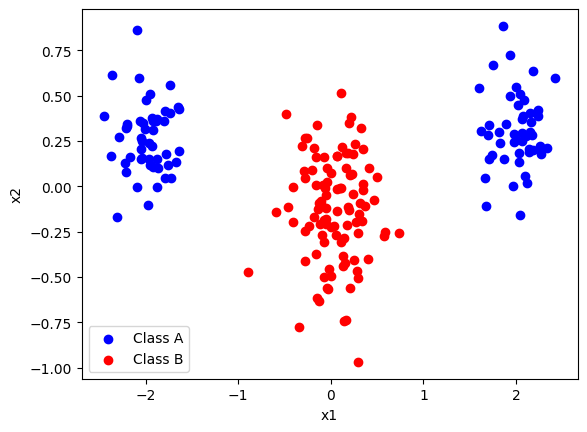

In [5]:
plt.scatter(classA[0, :], classA[1, :], color="blue", label="Class A")
plt.scatter(classB[0, :], classB[1, :], color="red", label="Class B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Helper functions

In [6]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from helper_functions import *

## Generalized delta rule

In [7]:
###### Activation function (as in the lab instructions) #####
def activation_function(h_in):
    phi = (2 / (1 + np.exp(-h_in))) - 1 #activation function
    d_phi = ((1 + phi) * (1 - phi)) / 2 #derrivative of activation function

    return phi, d_phi

##### Forward pass #####
def forward_pass(X, weights):
    #print("===== Forward pass =====")
    # List to keep track of what should be sent into the following hidden layer
    activations_list = [X] # First element is the input, and the last element correspond to the output (i.e. t)
    
    phi_and_d_phi = [] # Store results of the activation function (both the values and the derivate) 

    for i, W in enumerate(weights):
        #print(f"Layer {i}: W shape {W.shape}, input shape {activations_list[-1].shape}")
        h_in = W @ activations_list[-1] # Get the output from the latest calculated layer, and use it as input for next layer

        # Calcualte output of hidden layer and store both outpout and derivate (they will be used in back propogation)
        h_out, d_phi = activation_function(h_in)
        #print(f"Layer {i}: h_out shape {h_out.shape}, d_phi shape {d_phi.shape}")


        phi_and_d_phi.append((h_out, d_phi))

        # Calculate bias term and add it to phi (output of the layer), for all layers, except the last one
        if i < (len(weights) - 1):
            bias_term = h_out.shape[1]
            h_out = np.vstack(tup=(h_out, np.ones((1, bias_term))))

        activations_list.append(h_out)

    return activations_list, phi_and_d_phi

##### Backward pass #####
def backward_pass(targets, phi_and_d_phi, weights):
    #print("===== Backward pass =====")
    # Initialize list with the deltas. Makes it easier to call the correct delta when calculating hidden layers delta
    deltas = [None] * len(phi_and_d_phi)

    # Go through each element of phi_and_d_phi in reversed order. 
    # In the first iteration, i = len(phi_and_d_phi) - 1 (last element of phi_and_d_phi)
    for i, (h_out, d_phi) in reversed(list(enumerate(phi_and_d_phi))):
        # We handle output layer (last element of phi_and_d_phi) differently from hidden layers
        if i == len(phi_and_d_phi) - 1:
            d = (h_out - targets) * d_phi
            #print(f"Layer {i} (output): delta shape {d.shape}")
        else:
            v = weights[i + 1][:, :-1] # Drop the weighs for the bias, as the error is calculated based the weighs connecting inputs with nodes in hidden layer, or weighs connecting hiodden layer to outer layer
            #print(f"Layer {i} (hidden): v shape {v.shape}, v_transpose shape {np.transpose(v).shape}, previously calculated delta shape {deltas[i + 1].shape}, d_phi shape {d_phi.shape}")
            d = (np.transpose(v) @ deltas[i + 1]) * d_phi # Here we matrix multiply with the latest calculated delta
            #print(f"Layer {i} (hidden): delta shape {d.shape}")

        deltas[i] = d # Update the None value to the actual delta values, so the last element in deltas = delta for the output layer nodes

    return deltas

##### Weight update #####
def weight_update(alpha, eta, activations, deltas, old_weights, delta_w_prev):
    #print("===== Weight update =====")
    new_weights = [] # New updated weights
    new_delta_w = [] # Output the calculated delta_w which will be outputted and used as delta_w_prev in next epoch

    # Going from left to right in the network to update the weights. Only 2 times in our case (X and H, not the output)
    for i, old_W in enumerate(old_weights):
        #print("Update weights in layer: " + str(i))

        delta_w = (delta_w_prev[i] * alpha) - (deltas[i]@np.transpose(activations[i]) * (1 - alpha))
        W = old_W + eta * delta_w

        new_delta_w.append(delta_w)
        new_weights.append(W)

    return new_weights, new_delta_w
#Question here is: Do we use the activations we used before, or do we cacluate them new, based on the updated weights
# Answer; the activations should not be calculated again. In the next epoch we run the model with the new weights and the original input.
# These are inputted into the hidden layer, which outputs phi and the derivate of phi. This will be populated in the activation list in the forward pass
# as well as the output from the output layer. So basically;
# X (input) - never changes
# phi(WX) - recalculated in the forward pass each epoch
# output - recalculated in the forward pass each epoch
# So the list activations will be overwritten each epoch

##### Generalized Delta Rule #####
def generalised_delta_rule(
        train_X,
        train_targets,
        val_X=None,
        val_targets=None,
        epoch:int = 100,
        eta:float = 0.01,
        alpha: float=0.9,
        hidden_nodes: int=5,
        approximate_function: bool = False, 
    ):
    # Initialize weights
    weights, delta_w_prev = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[hidden_nodes], output_nodes=1)

    epoch_list = []
    train_mse_list = []
    train_ratio_list = []
    val_mse_list = []
    val_ratio_list = []

    for i in range(epoch):
        activation_list, phi_and_d_phi = forward_pass(X=train_X, weights=weights)
        if val_X is not None:
            val_activation_list, _ = forward_pass(X=val_X, weights=weights)

        deltas = backward_pass(targets=train_targets, phi_and_d_phi=phi_and_d_phi, weights=weights)
        weights, delta_w_prev = weight_update(alpha=alpha, eta=eta, deltas=deltas, activations=activation_list, old_weights=weights, delta_w_prev=delta_w_prev)

        # Print training accuracy every 10 epochs
        if i%10 == 0:
            train_predicted = activation_list[-1].ravel() # Make the arry 1 dimensional
            # Calculate the MSE and the accuracy ratio
            train_mse = mse(targets=train_targets, predicted=train_predicted)
            train_correct_class_ratio = accuracy(targets=train_targets, predicted=train_predicted)
            # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
            epoch_list.append(i)
            train_mse_list.append(train_mse)
            train_ratio_list.append(train_correct_class_ratio)

            if approximate_function == True:
                visualize_function_approx(predicted=train_predicted)
            
            if val_X is not None:
                val_predicted = val_activation_list[-1].ravel() # Make the arry 1 dimensional
                # Calculate the MSE and the accuracy ratio
                val_mse = mse(targets=val_targets, predicted=val_predicted)
                val_correct_class_ratio = accuracy(targets=val_targets, predicted=val_predicted)
                # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
                
                val_mse_list.append(val_mse)
                val_ratio_list.append(val_correct_class_ratio)
                
            
            
    
    print(f"Hidden nodes: {hidden_nodes}, eta: {eta}, alpha: {alpha}")
    plot_learning_curve(
        epochs=epoch_list,
        train_mse=train_mse_list,
        train_ratios=train_ratio_list,
        val_mse=val_mse_list,
        val_ratios=val_ratio_list
    )


## Testing

In [8]:
# classA, classB, X, targets = data_generator(mA=[2.0, 0.3])
# # Create weights for 2 perceptron layer (1 hidden layer and 1 output layer)
# weights, delta_w_prev = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[5], output_nodes=1)

# # Forward pass
# activation_list, phi_and_d_phi = forward_pass(X=X, weights=weights)

# # Backward pass
# deltas = backward_pass(targets=targets, phi_and_d_phi=phi_and_d_phi, weights=weights)

# # Update weights
# weights_updated, delta_w_prev = weight_update(alpha=0.9, eta = 0.01, deltas=deltas, activations=activation_list, old_weights=weights, delta_w_prev=delta_w_prev)

# print(deltas[0].shape)
# print(activation_list[0].shape)
# print(weights[0].shape)
# print("Sanity check that weights are updated")
# print(f"First weights: {weights}")
# print(f"Updated weights: {weights_updated}")

# print(targets.shape)
# print(targets)
# print(activation_list[-1].ravel().shape)

# print(targets - activation_list[-1].ravel())

# print(type(targets))
# print(type(activation_list[-1]))

In [9]:
# for i in activation_list:
#     print(i.shape)

In [10]:
# for i in weights:
#     print(i.shape)

In [11]:
a = np.ones(shape=(2, 2))
b = np.random.randn(2, 2)
print(a)
print(b)
print(a*b)

[[1. 1.]
 [1. 1.]]
[[ 1.03759945  0.42439215]
 [-0.45813083 -0.5216073 ]]
[[ 1.03759945  0.42439215]
 [-0.45813083 -0.5216073 ]]


 ## Testing the backprop

In [12]:
# classA, classB, X, targets, _, _ = data_generator(mA=[2.0, 0.3])
# generalised_delta_rule(X, targets, eta=0.01)

## Assignment - Part 1

In [13]:
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3])

Hidden nodes: 1, eta: 0.01, alpha: 0.9


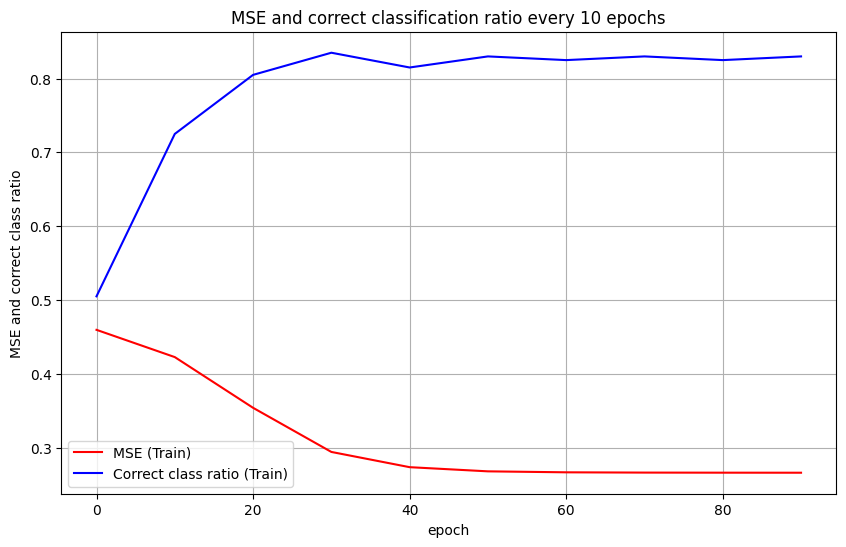

Hidden nodes: 2, eta: 0.01, alpha: 0.9


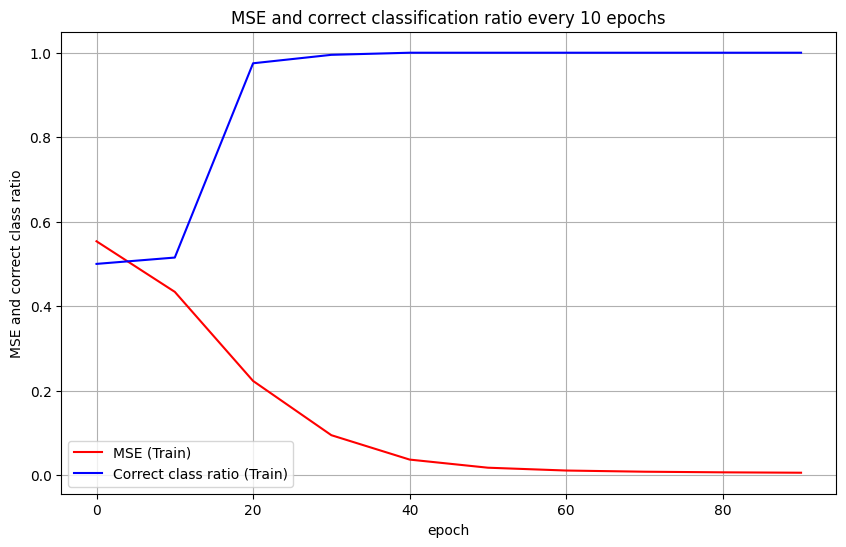

Hidden nodes: 3, eta: 0.01, alpha: 0.9


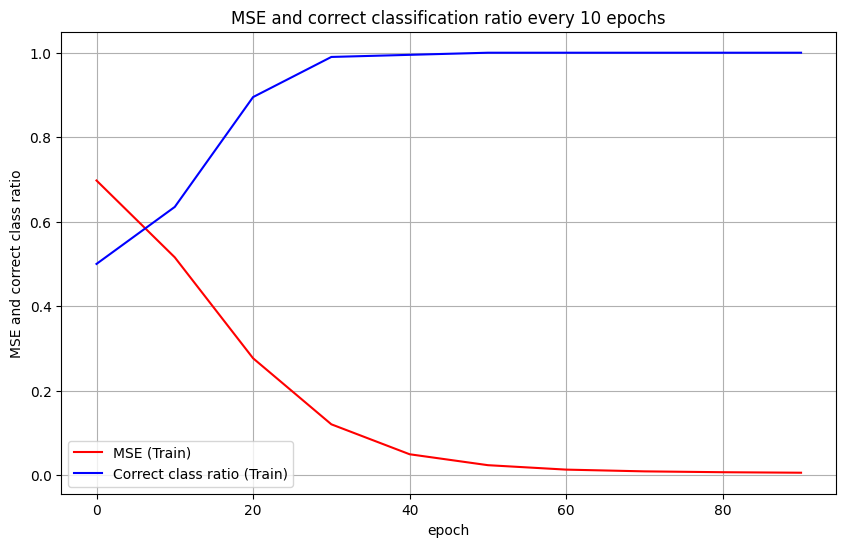

Hidden nodes: 4, eta: 0.01, alpha: 0.9


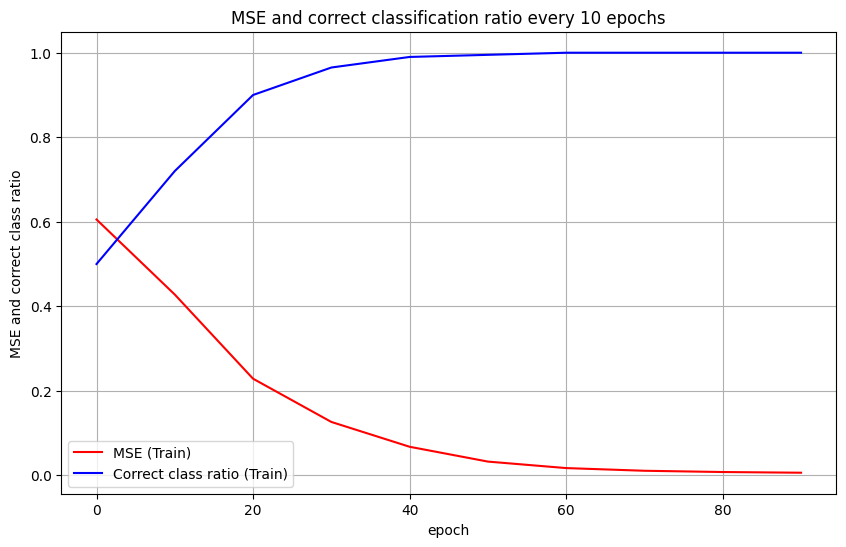

Hidden nodes: 5, eta: 0.01, alpha: 0.9


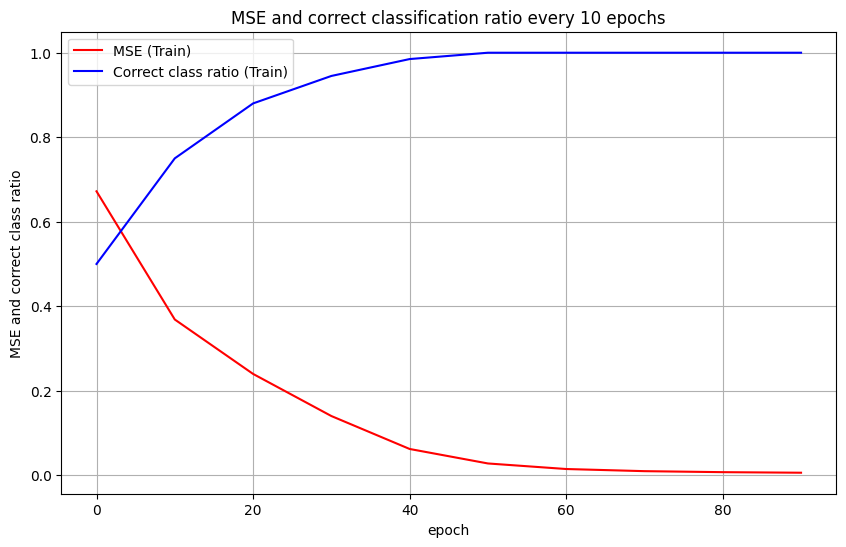

Hidden nodes: 6, eta: 0.01, alpha: 0.9


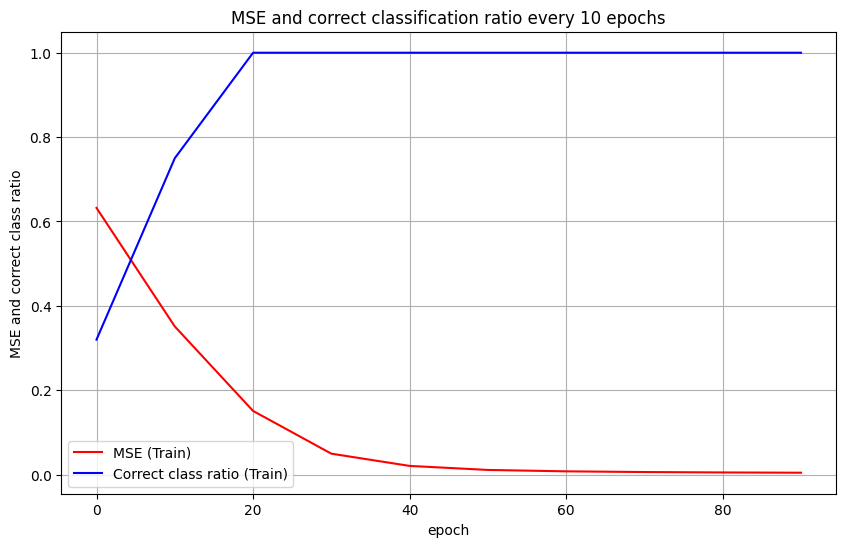

Hidden nodes: 7, eta: 0.01, alpha: 0.9


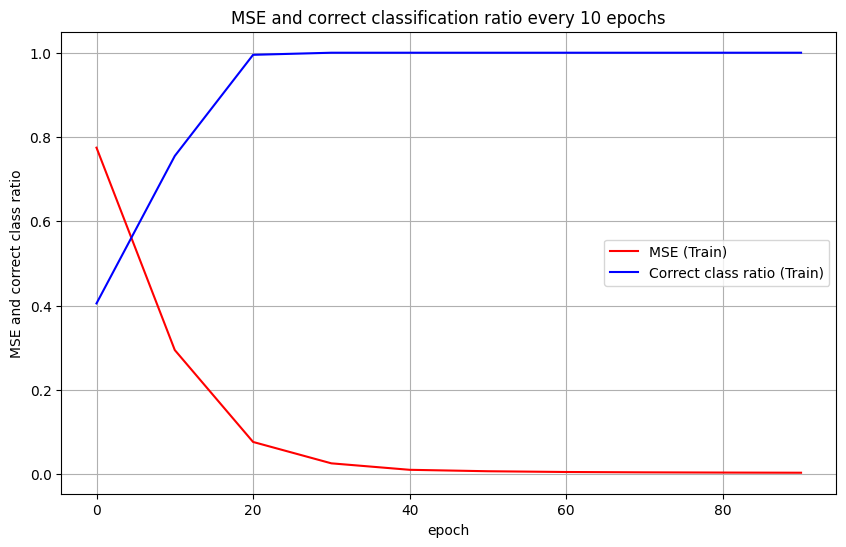

Hidden nodes: 8, eta: 0.01, alpha: 0.9


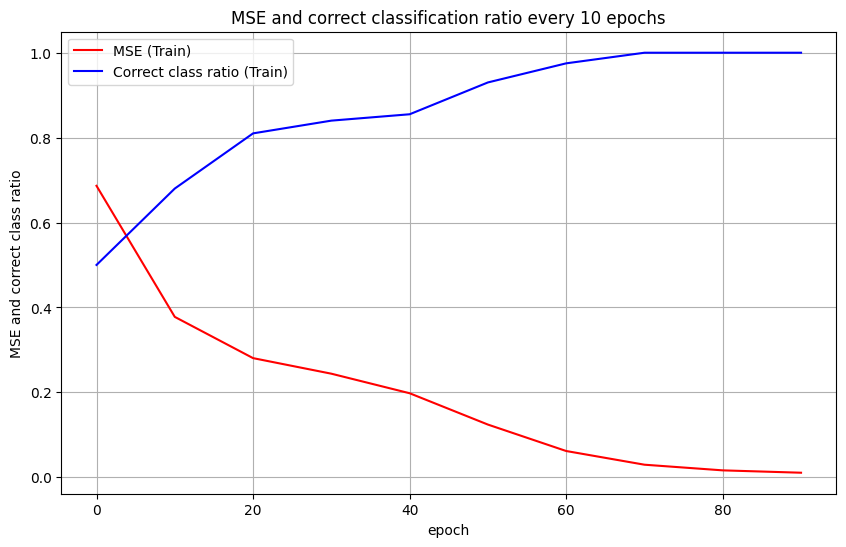

Hidden nodes: 9, eta: 0.01, alpha: 0.9


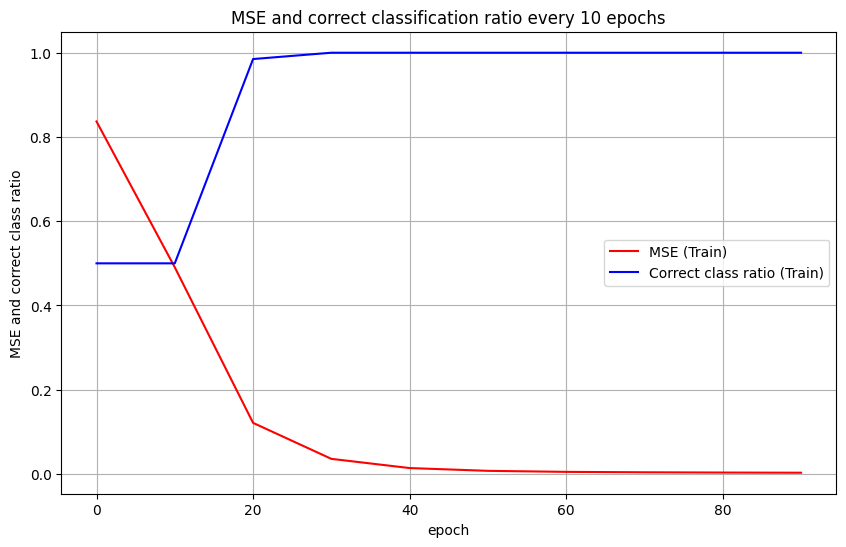

Hidden nodes: 10, eta: 0.01, alpha: 0.9


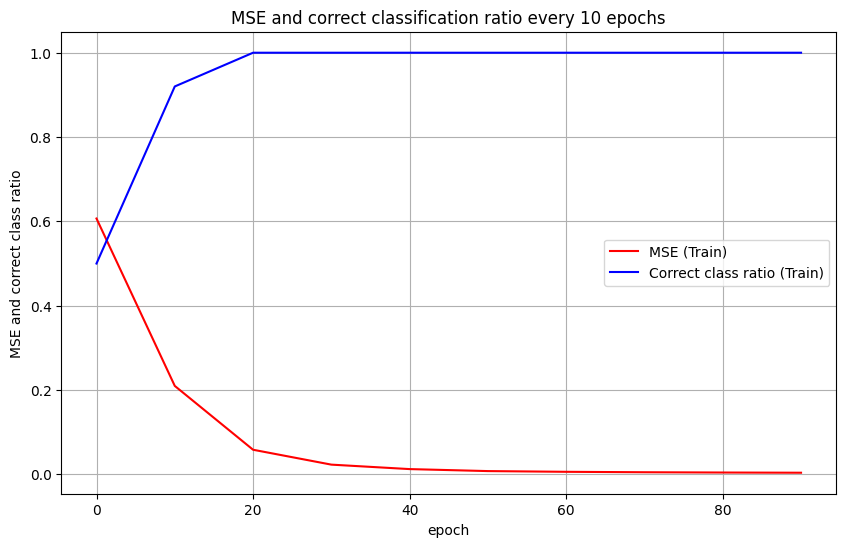

Hidden nodes: 11, eta: 0.01, alpha: 0.9


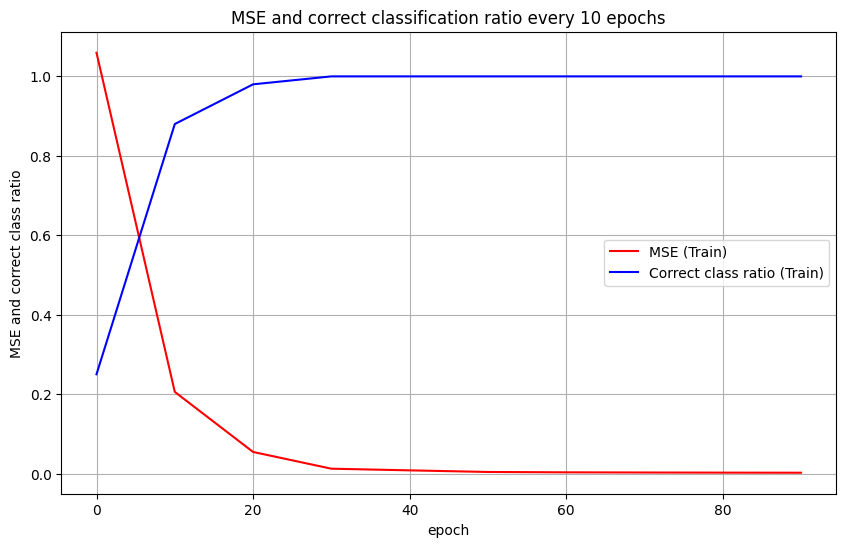

Hidden nodes: 12, eta: 0.01, alpha: 0.9


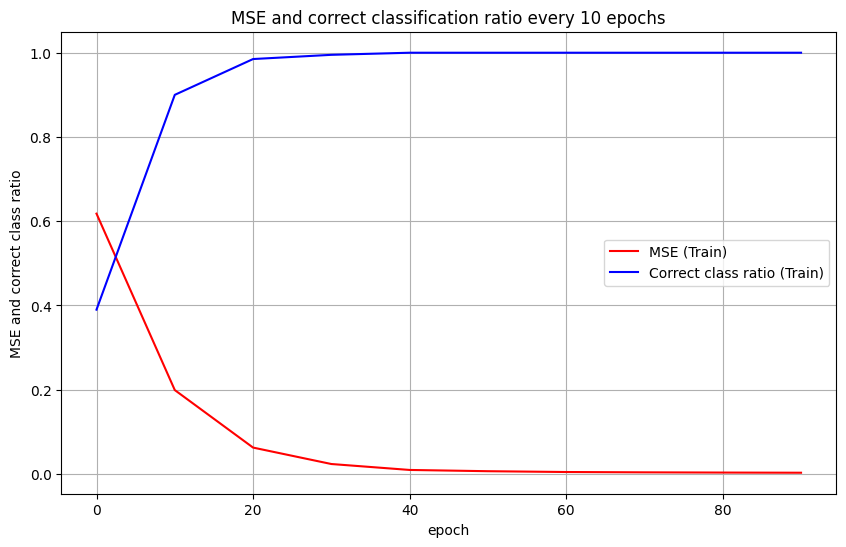

Hidden nodes: 13, eta: 0.01, alpha: 0.9


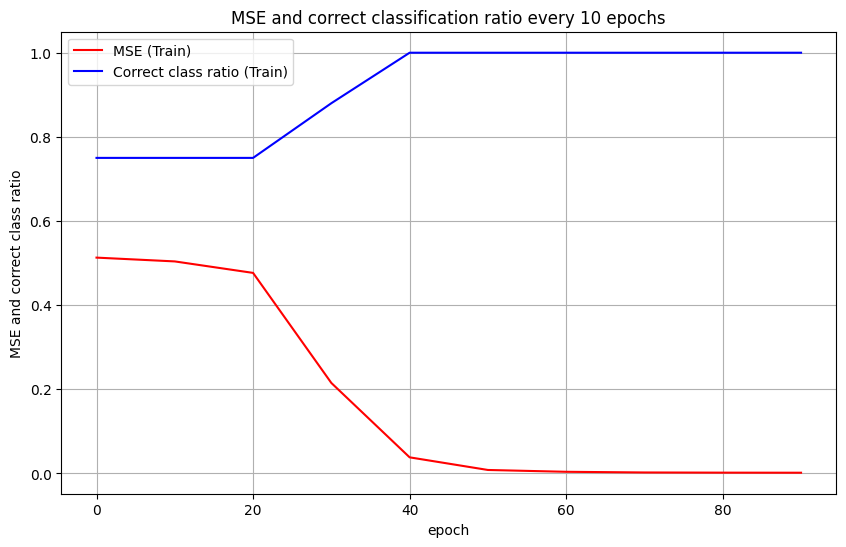

Hidden nodes: 14, eta: 0.01, alpha: 0.9


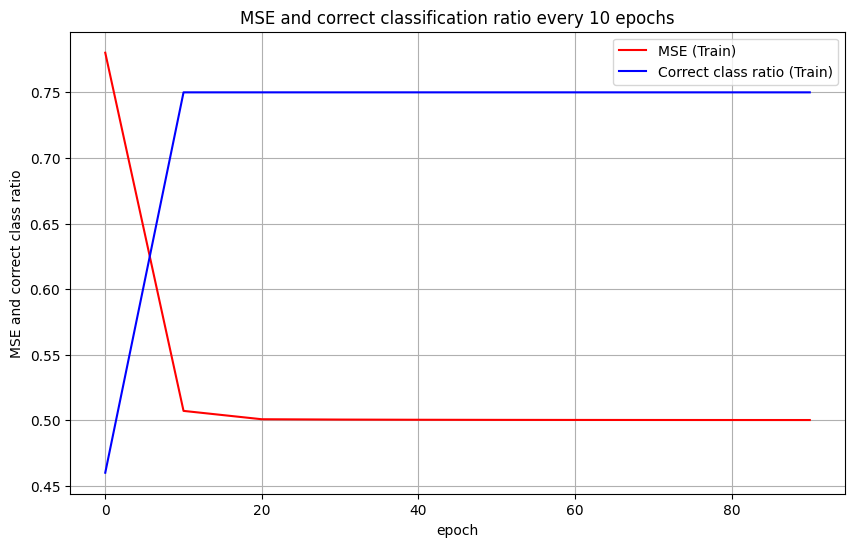

In [14]:
# Question 1 - Modify number of hidden nodes and demonstrate effect of the size of the hidden layer on performance
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Hidden nodes: 1, eta: 0.01, alpha: 0.9


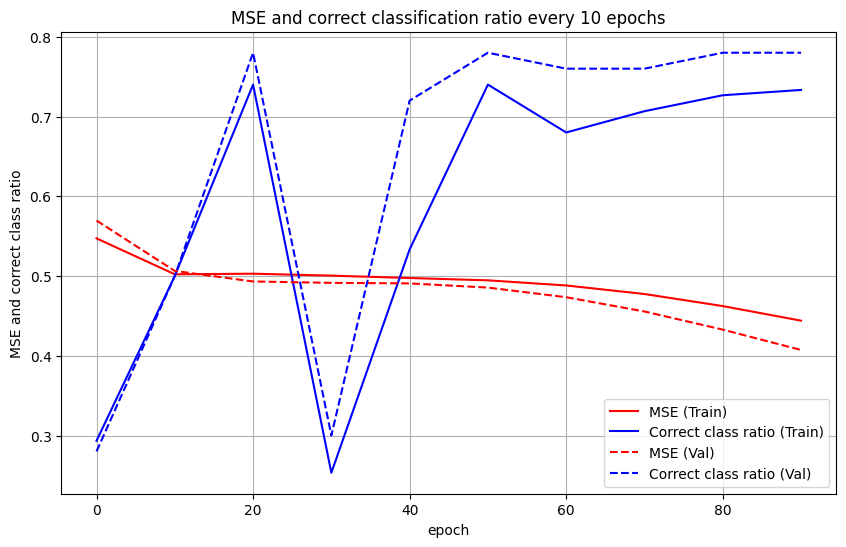

Hidden nodes: 2, eta: 0.01, alpha: 0.9


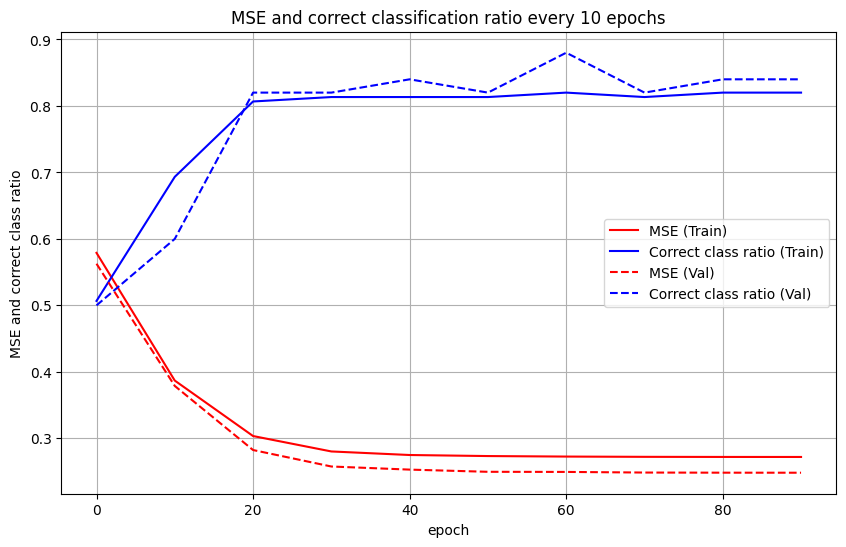

Hidden nodes: 3, eta: 0.01, alpha: 0.9


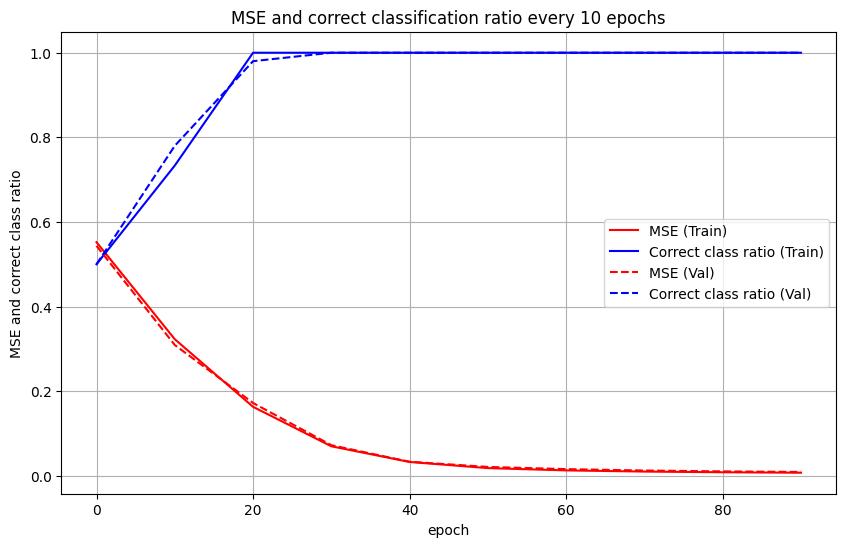

Hidden nodes: 4, eta: 0.01, alpha: 0.9


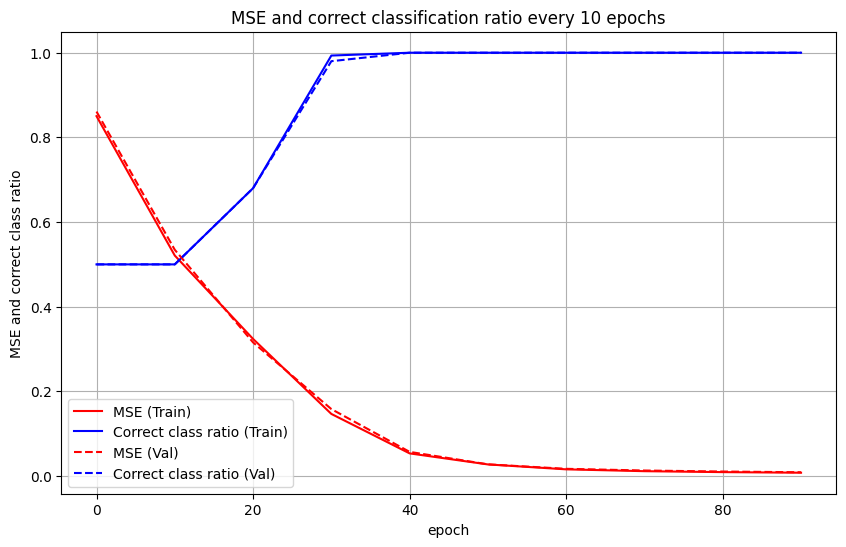

Hidden nodes: 5, eta: 0.01, alpha: 0.9


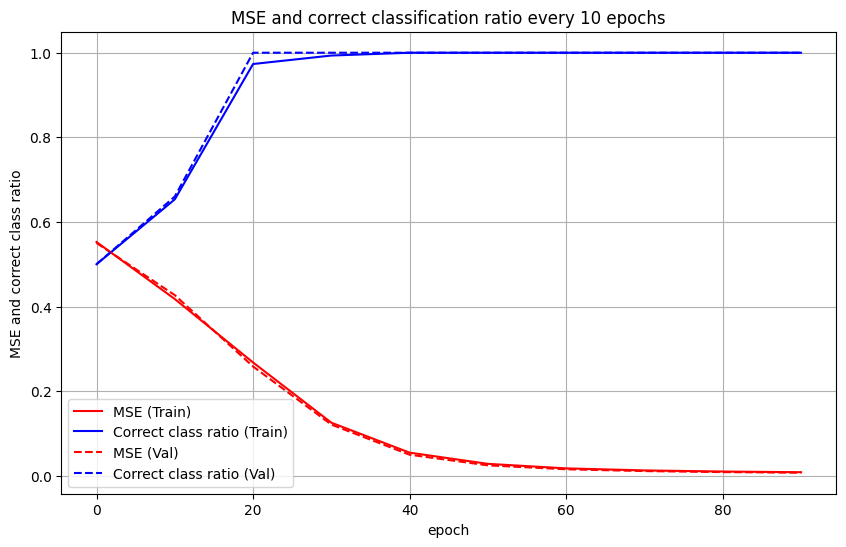

Hidden nodes: 6, eta: 0.01, alpha: 0.9


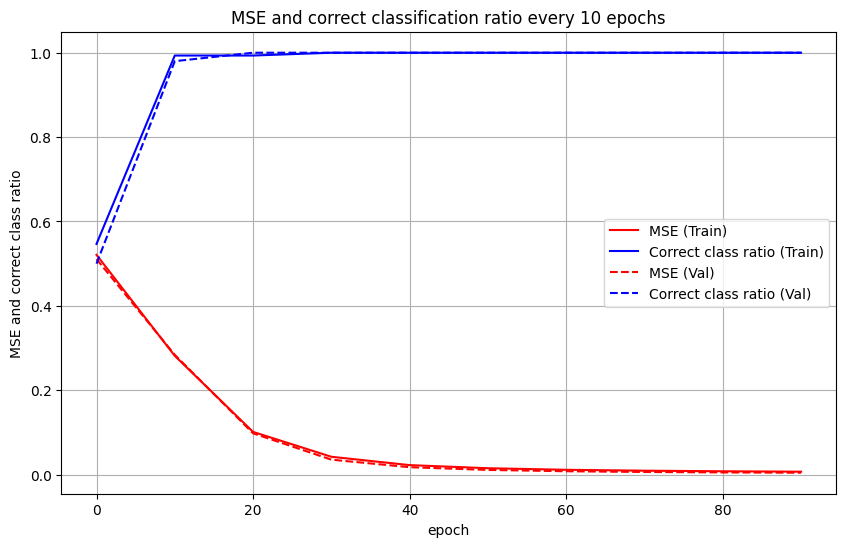

Hidden nodes: 7, eta: 0.01, alpha: 0.9


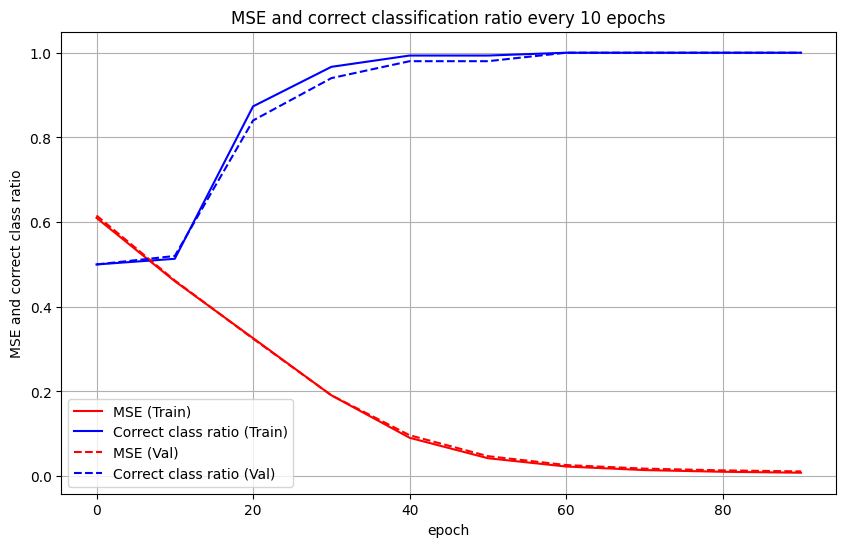

Hidden nodes: 8, eta: 0.01, alpha: 0.9


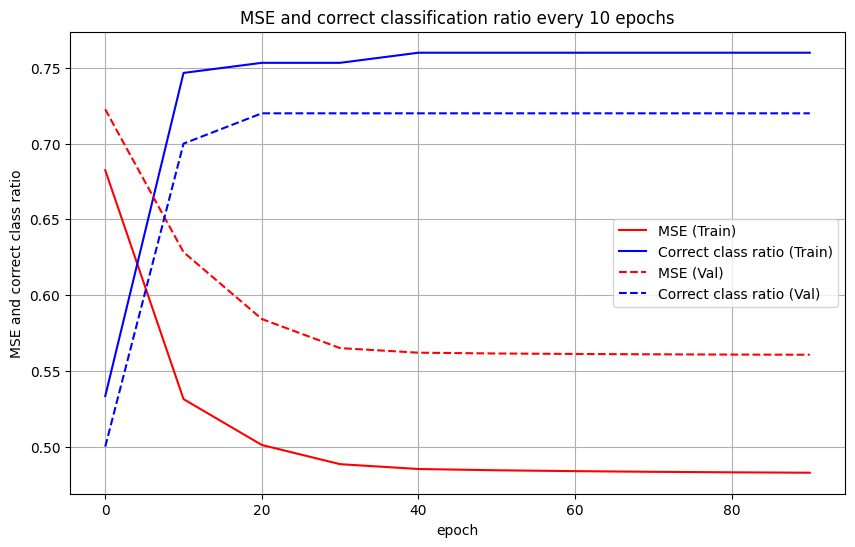

Hidden nodes: 9, eta: 0.01, alpha: 0.9


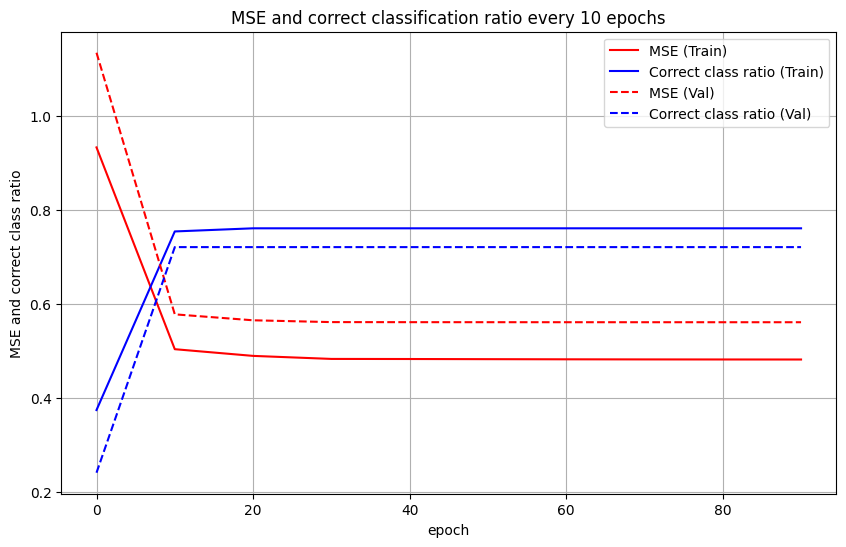

Hidden nodes: 10, eta: 0.01, alpha: 0.9


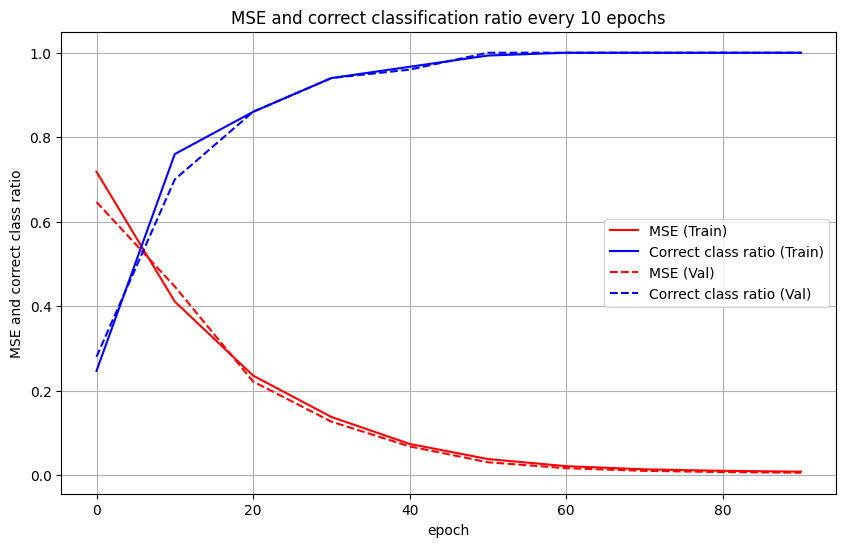

Hidden nodes: 11, eta: 0.01, alpha: 0.9


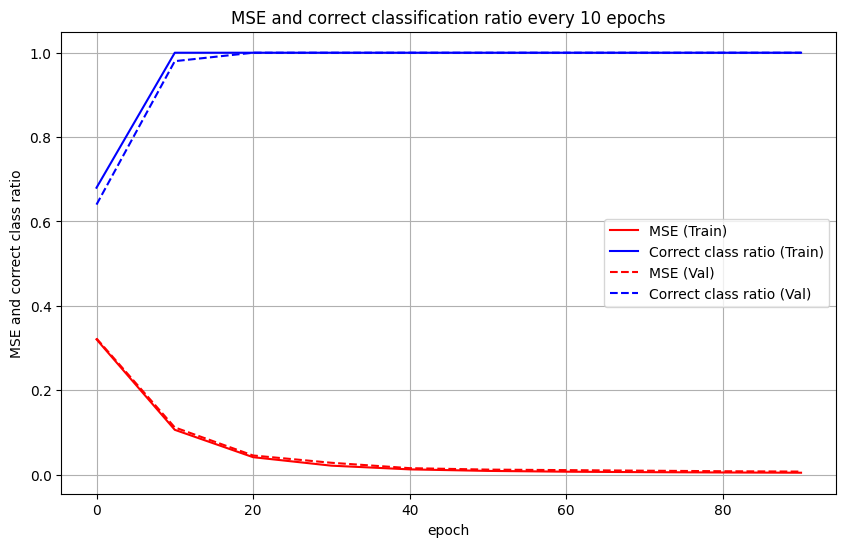

Hidden nodes: 12, eta: 0.01, alpha: 0.9


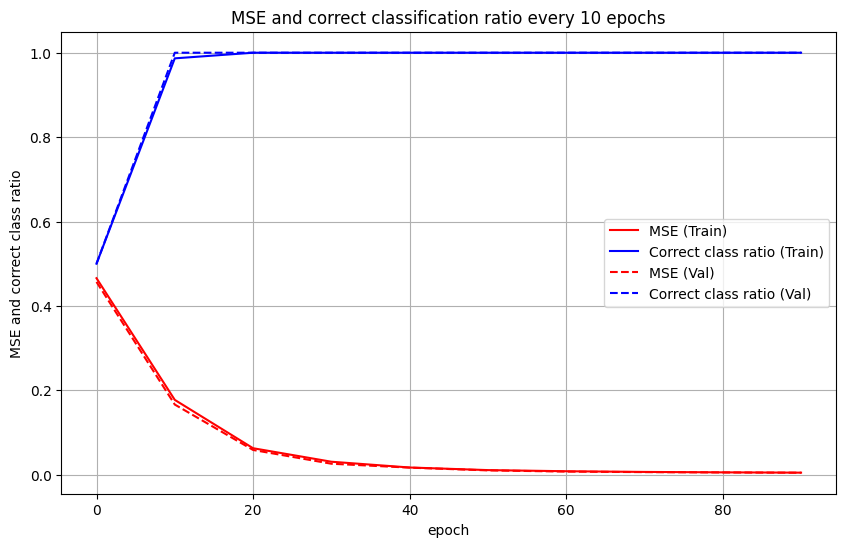

Hidden nodes: 13, eta: 0.01, alpha: 0.9


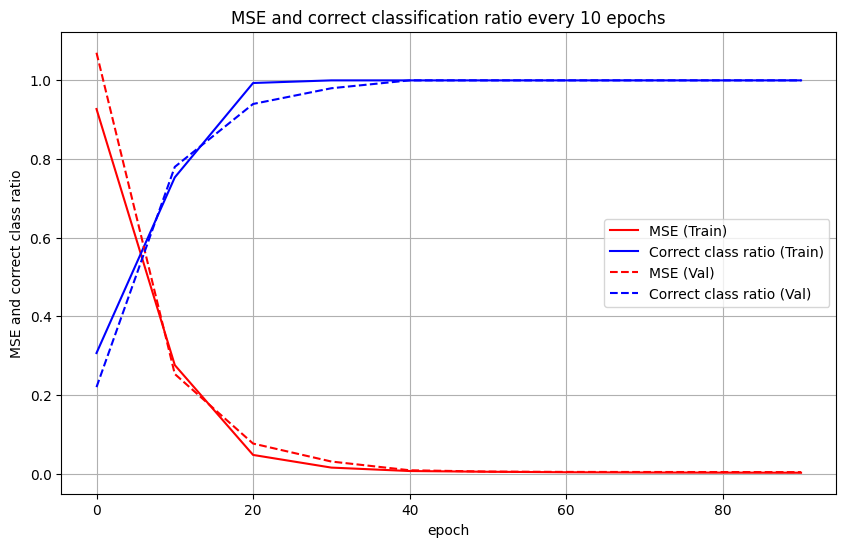

Hidden nodes: 14, eta: 0.01, alpha: 0.9


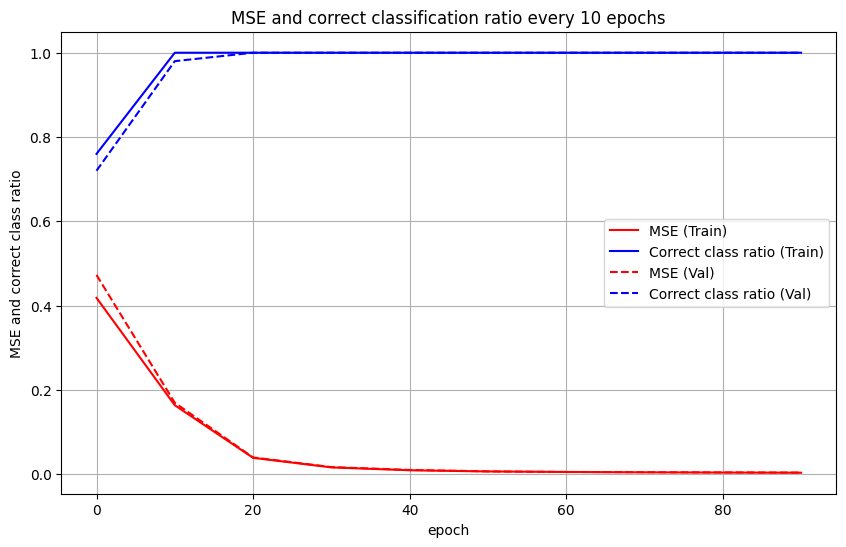

In [15]:
## Question 2 - Work with val data (75% training data and 25% validation data for each class)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=0.75, sampleB=0.75, special_A_subsample=False)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Hidden nodes: 1, eta: 0.01, alpha: 0.9


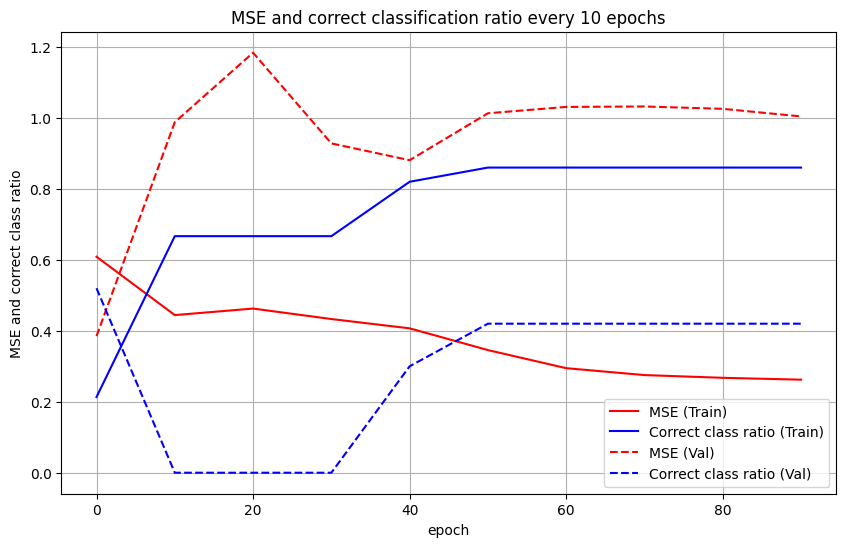

Hidden nodes: 2, eta: 0.01, alpha: 0.9


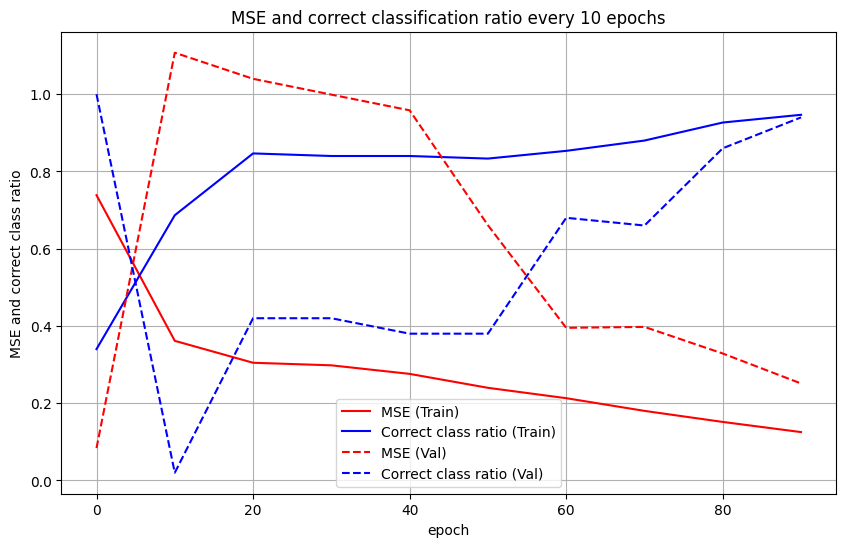

Hidden nodes: 3, eta: 0.01, alpha: 0.9


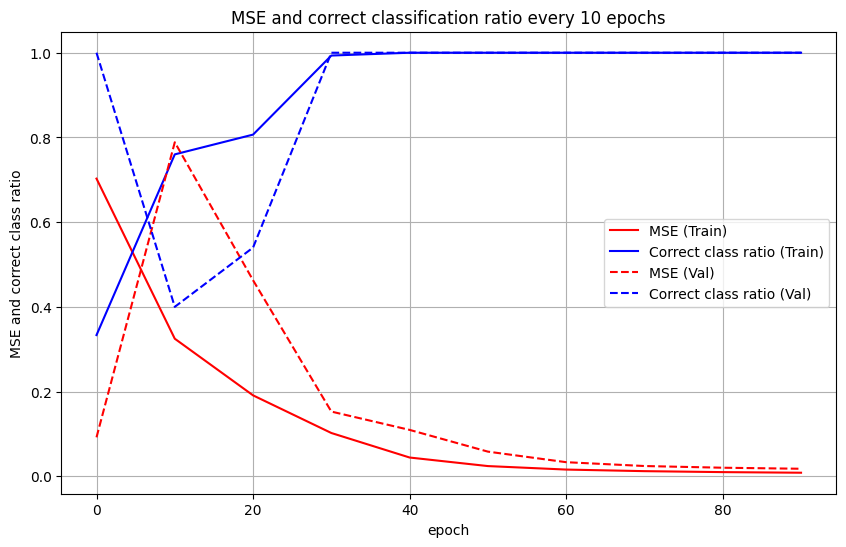

Hidden nodes: 4, eta: 0.01, alpha: 0.9


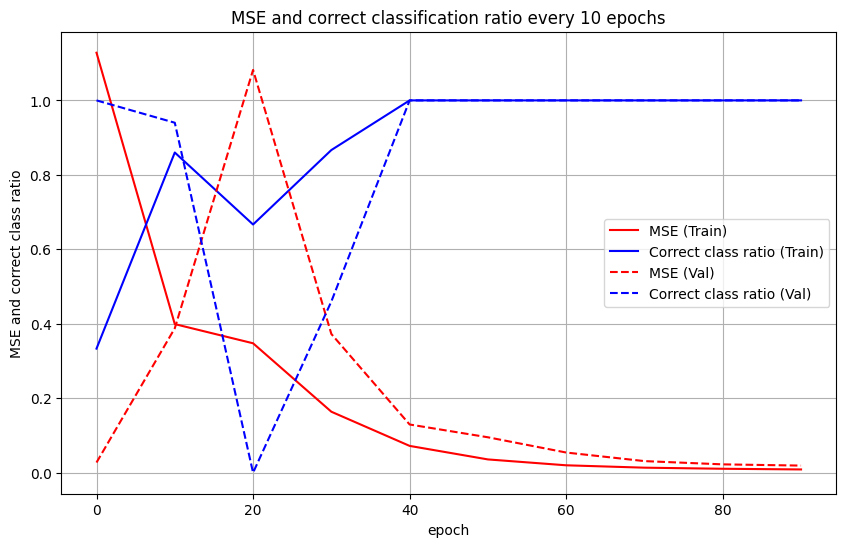

Hidden nodes: 5, eta: 0.01, alpha: 0.9


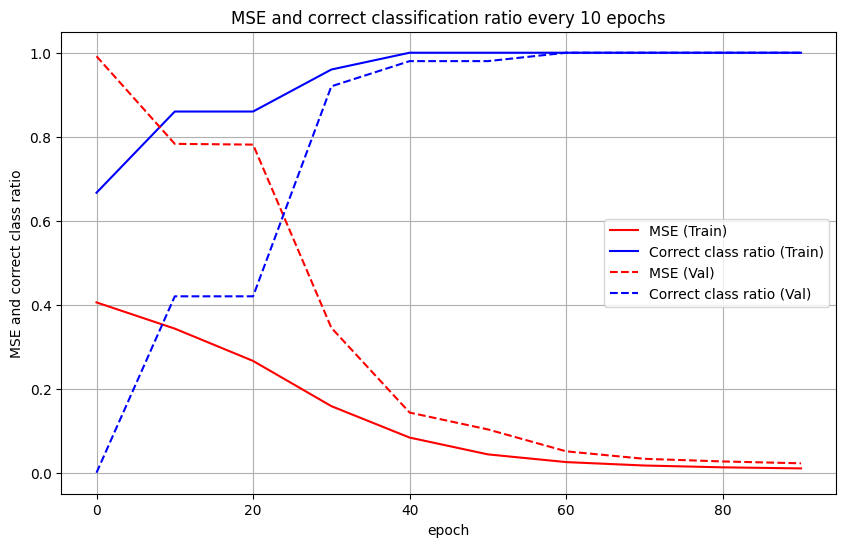

Hidden nodes: 6, eta: 0.01, alpha: 0.9


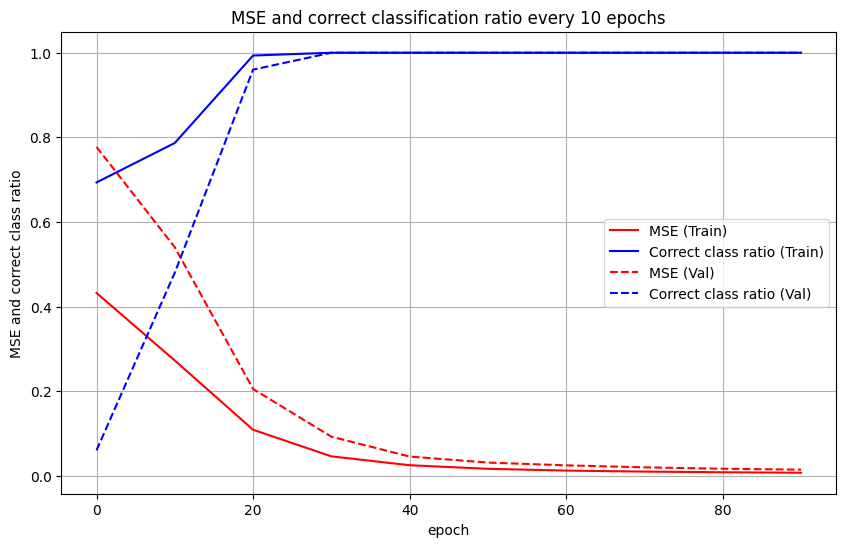

Hidden nodes: 7, eta: 0.01, alpha: 0.9


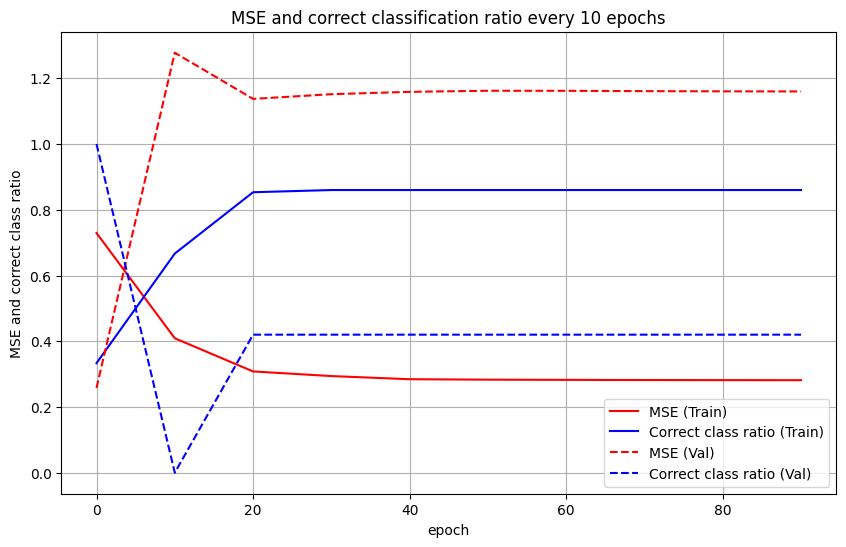

Hidden nodes: 8, eta: 0.01, alpha: 0.9


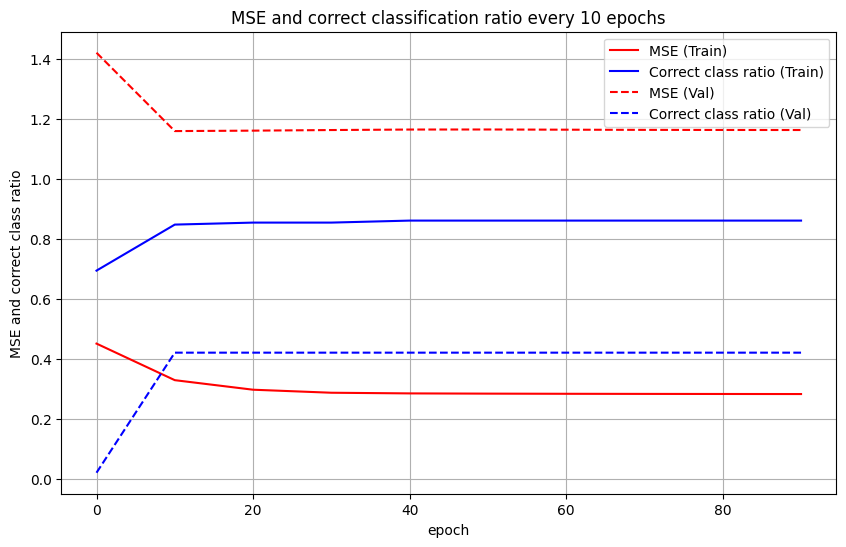

Hidden nodes: 9, eta: 0.01, alpha: 0.9


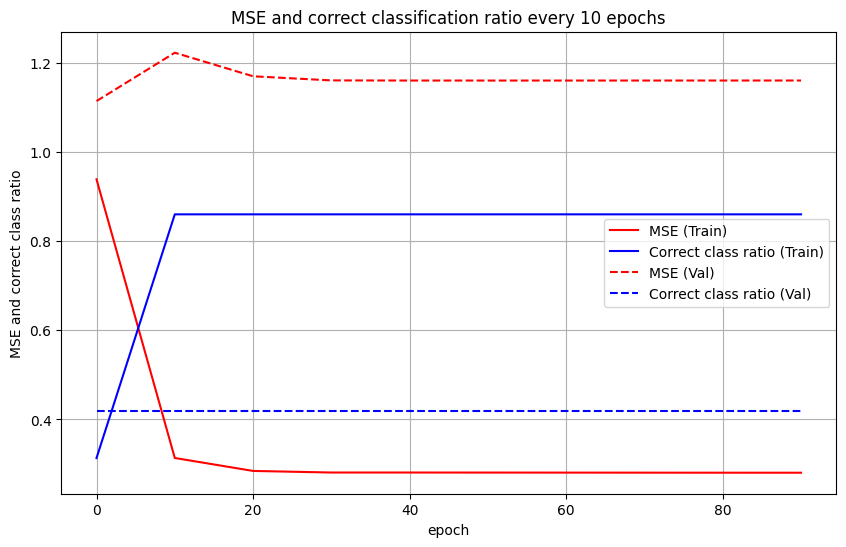

Hidden nodes: 10, eta: 0.01, alpha: 0.9


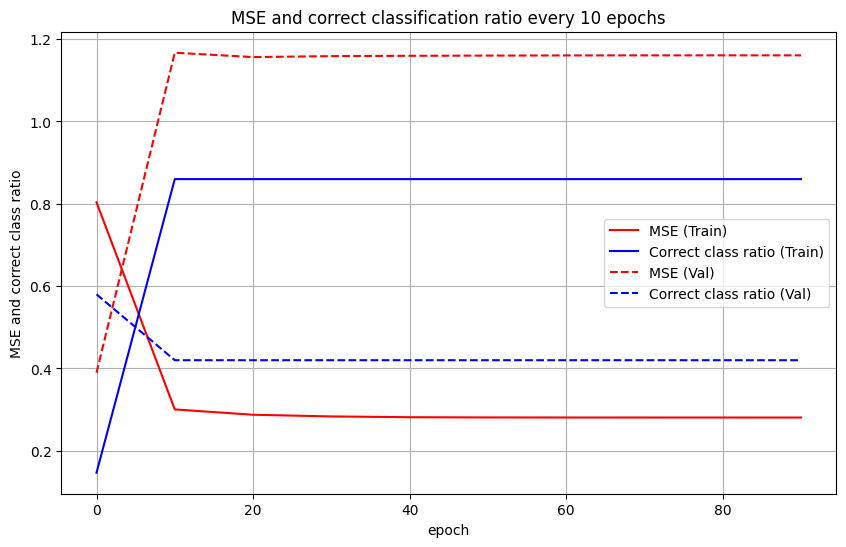

Hidden nodes: 11, eta: 0.01, alpha: 0.9


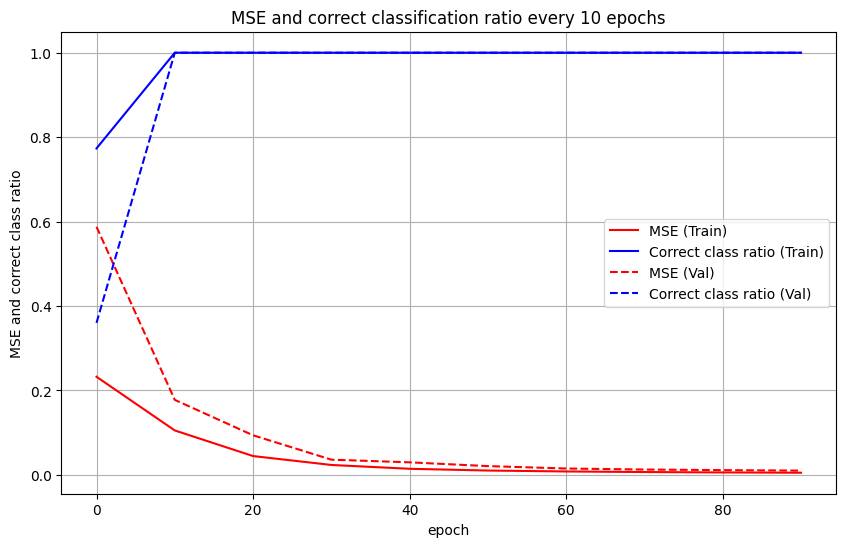

Hidden nodes: 12, eta: 0.01, alpha: 0.9


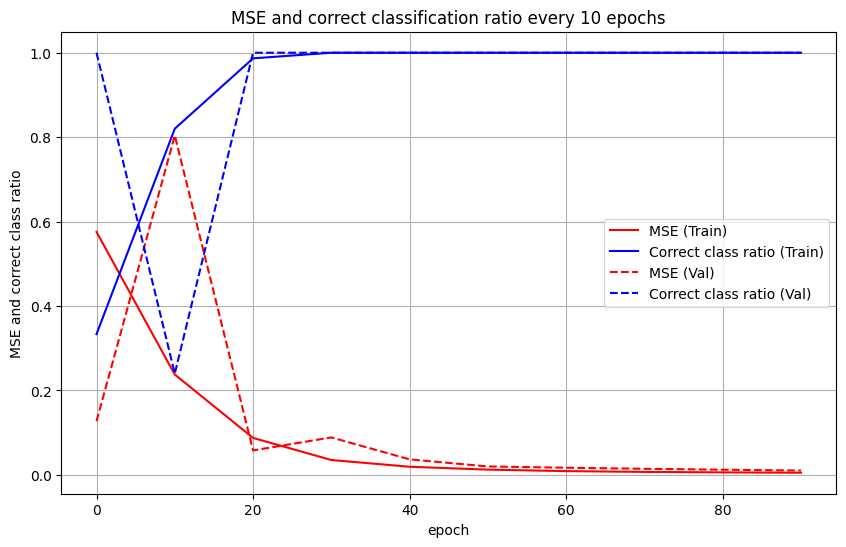

Hidden nodes: 13, eta: 0.01, alpha: 0.9


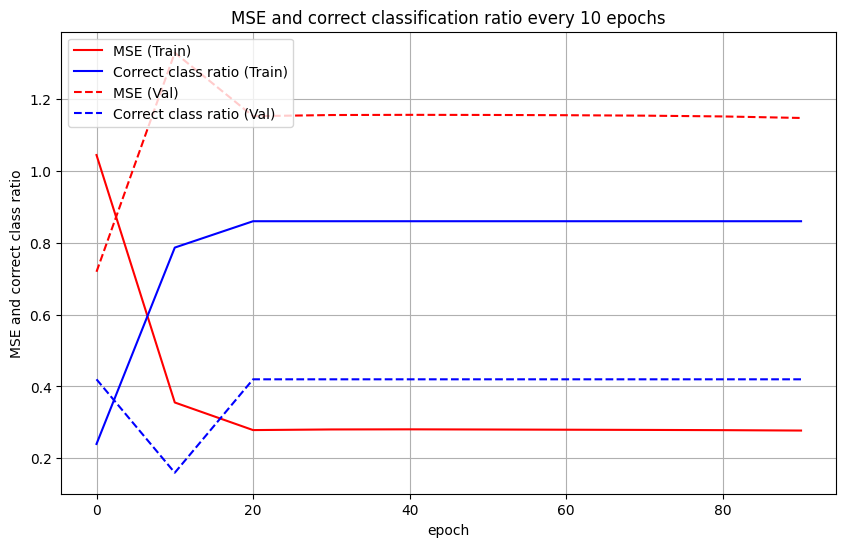

Hidden nodes: 14, eta: 0.01, alpha: 0.9


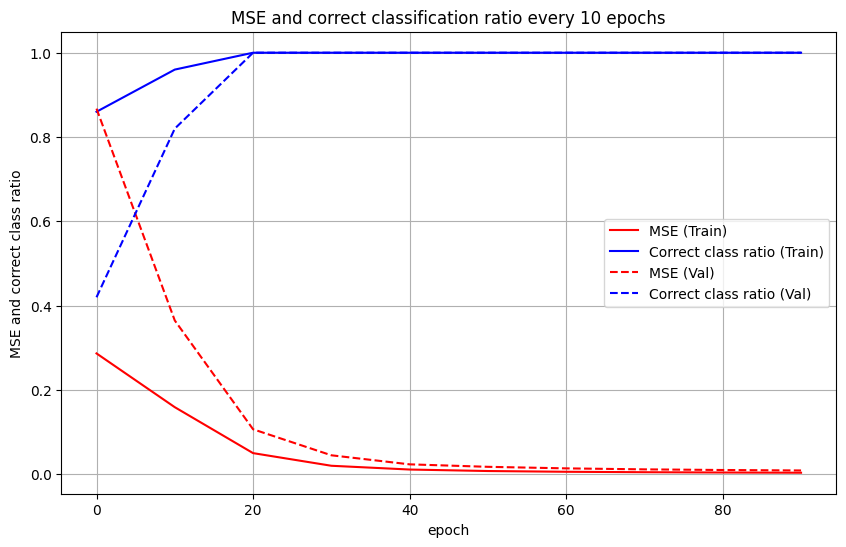

In [16]:
## Question 2 - Work with val data (50% training data and 50% validation data for class A only)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=0.50, sampleB=1.0, special_A_subsample=False)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Fixing the special case subsample of class A
Hidden nodes: 1, eta: 0.01, alpha: 0.9


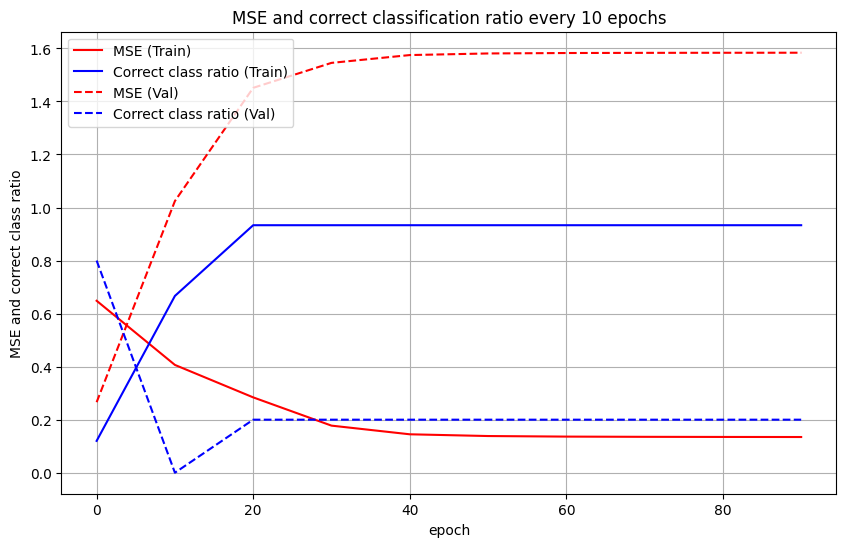

Hidden nodes: 2, eta: 0.01, alpha: 0.9


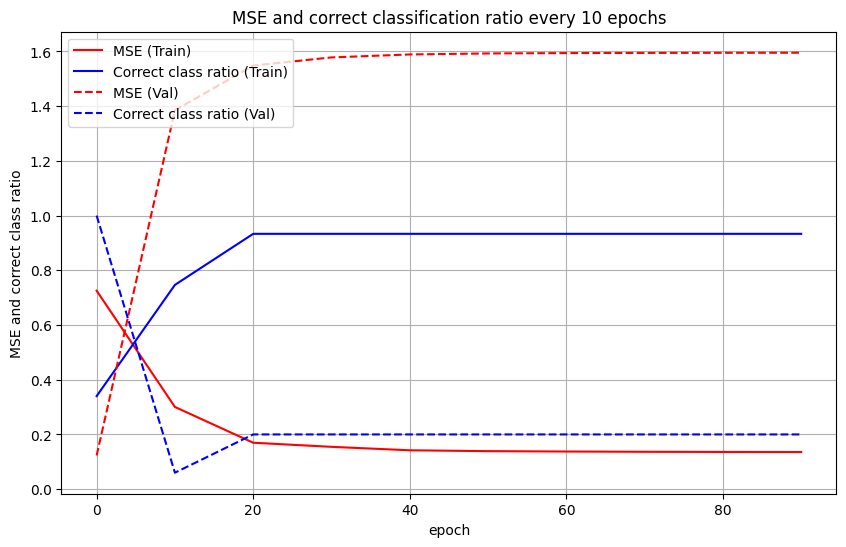

Hidden nodes: 3, eta: 0.01, alpha: 0.9


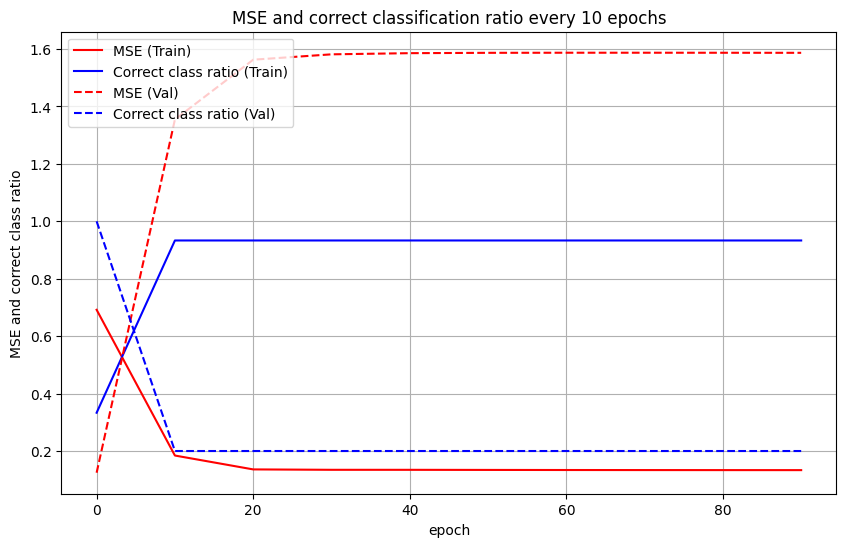

Hidden nodes: 4, eta: 0.01, alpha: 0.9


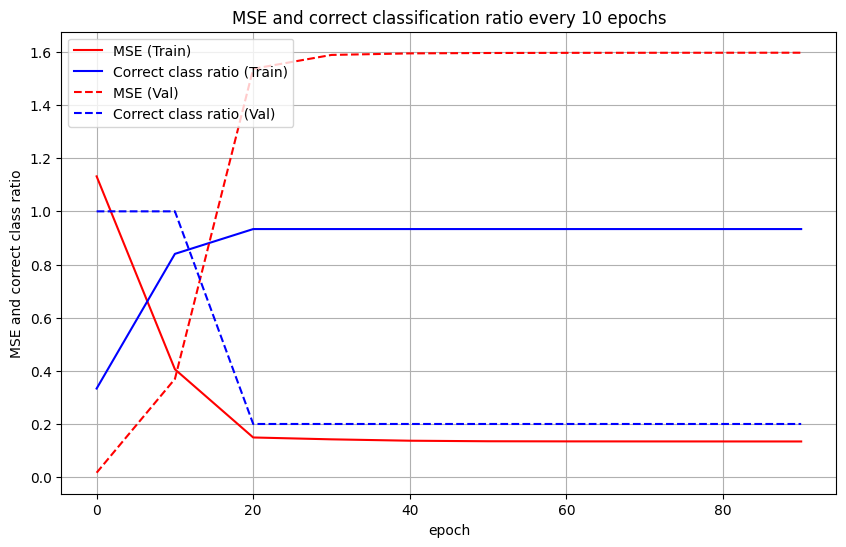

Hidden nodes: 5, eta: 0.01, alpha: 0.9


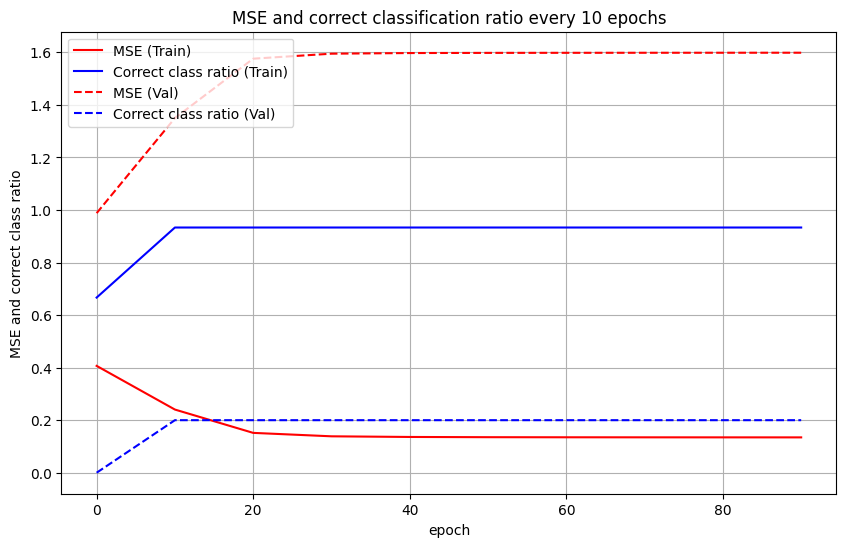

Hidden nodes: 6, eta: 0.01, alpha: 0.9


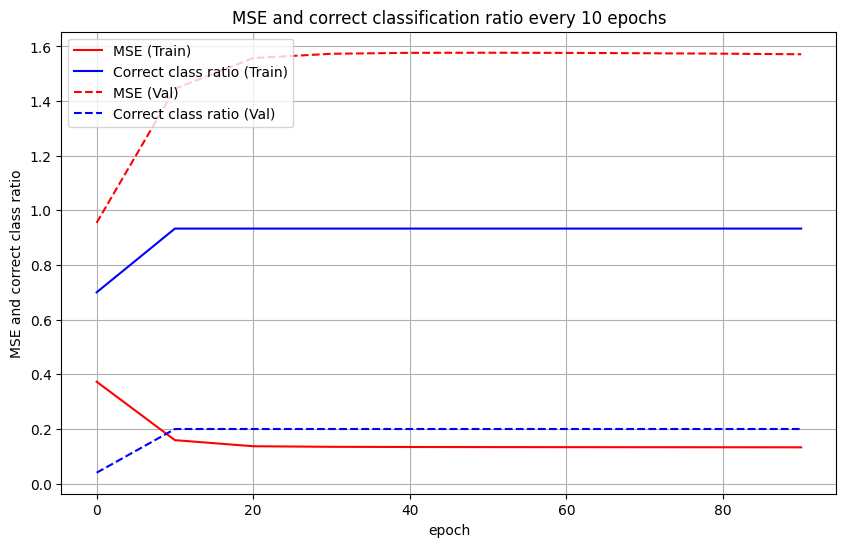

Hidden nodes: 7, eta: 0.01, alpha: 0.9


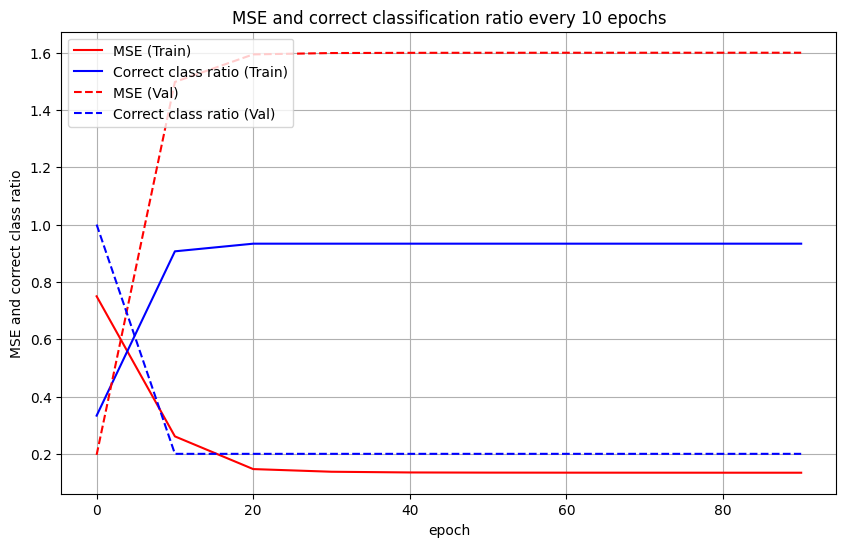

Hidden nodes: 8, eta: 0.01, alpha: 0.9


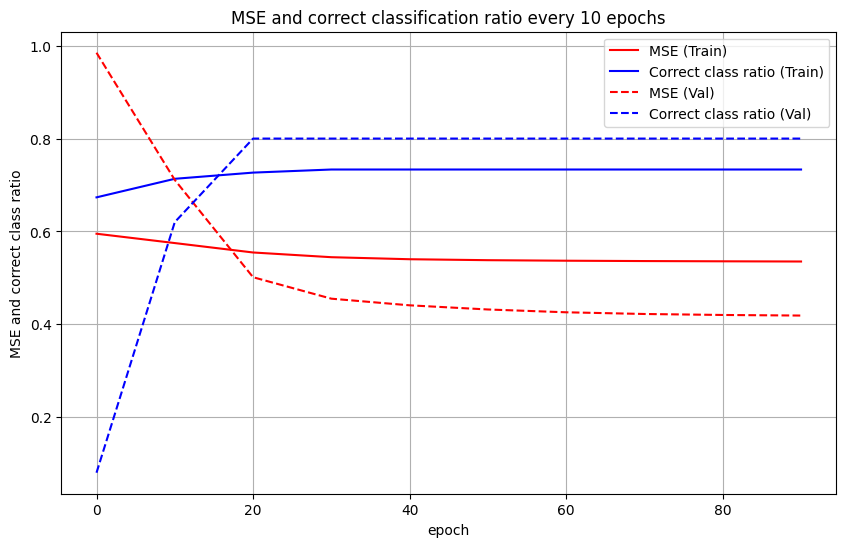

Hidden nodes: 9, eta: 0.01, alpha: 0.9


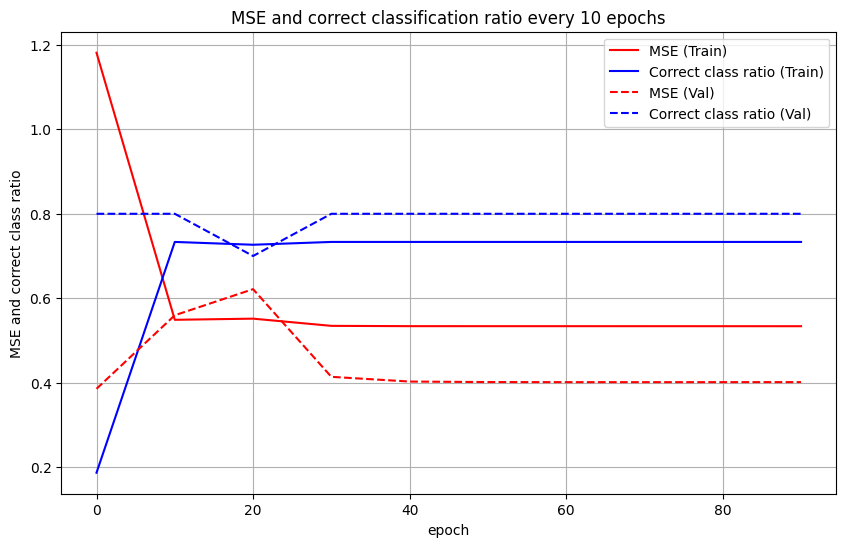

Hidden nodes: 10, eta: 0.01, alpha: 0.9


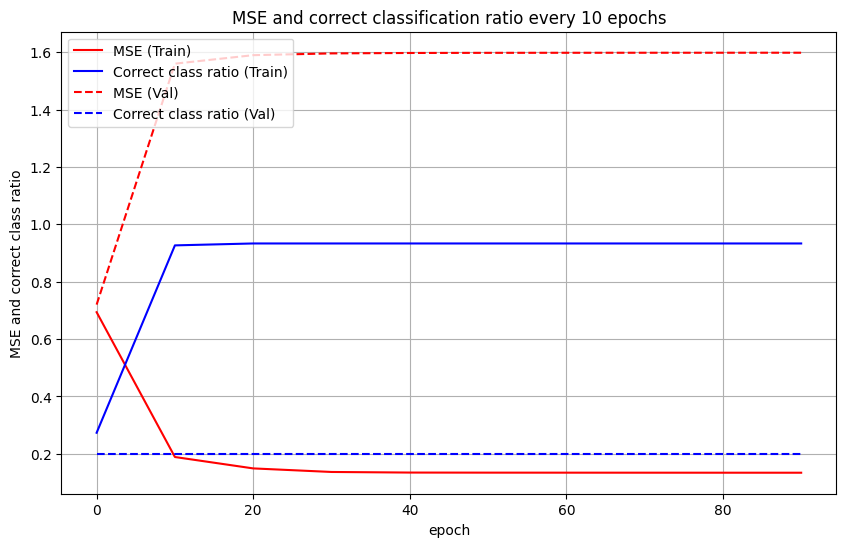

Hidden nodes: 11, eta: 0.01, alpha: 0.9


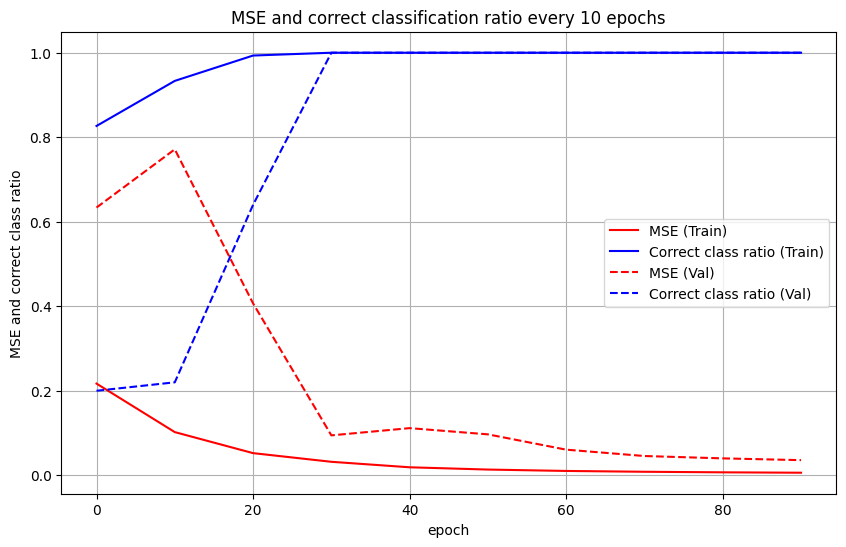

Hidden nodes: 12, eta: 0.01, alpha: 0.9


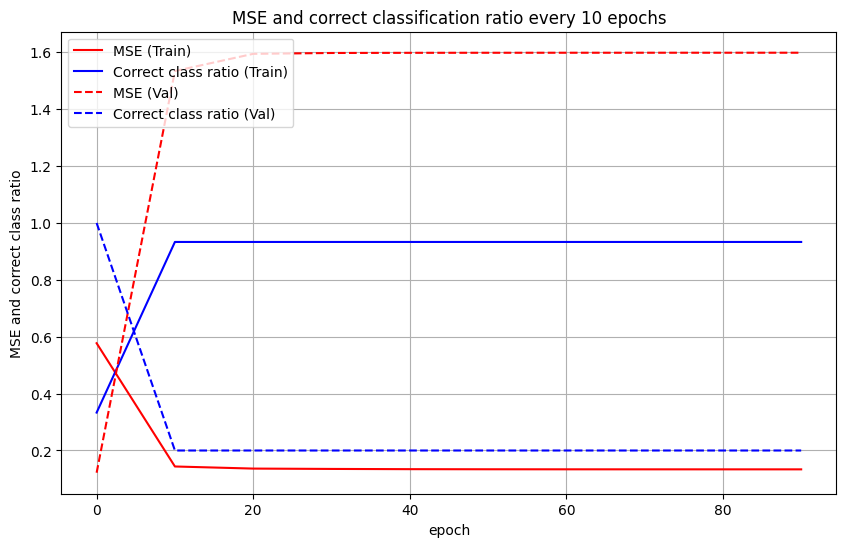

Hidden nodes: 13, eta: 0.01, alpha: 0.9


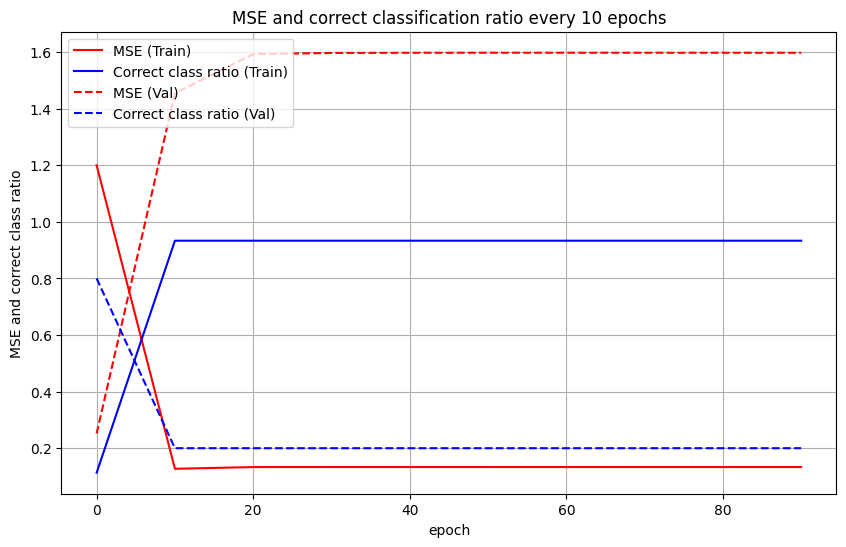

Hidden nodes: 14, eta: 0.01, alpha: 0.9


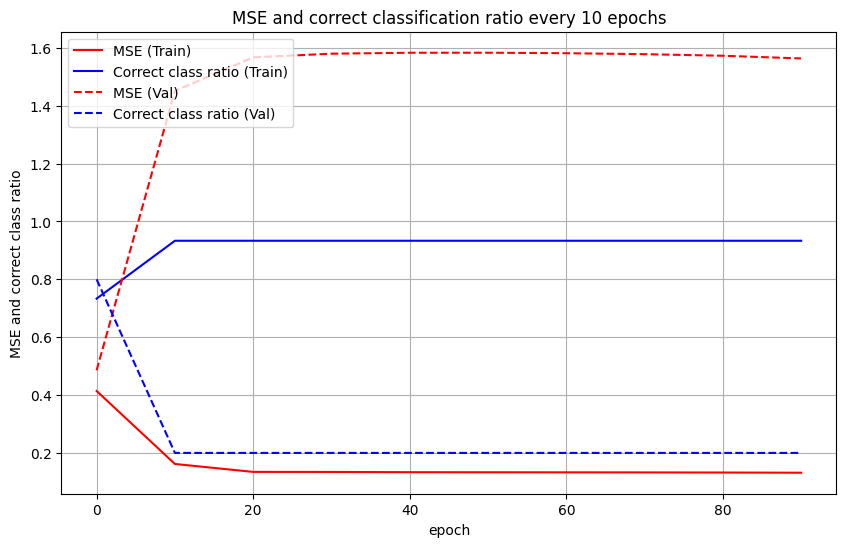

In [17]:
## Question 2 - Work with val data (special case; 20% of classA[0] < 0 and 80% of classA[0] > 0 for training, remaining for validation)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=1.0, sampleB=1.0, special_A_subsample=True)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

# Lab part 2

In [18]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from helper_functions import mse

In [19]:
###### Activation function (as in the lab instructions) #####
def activation_function(h_in):
    phi = (2 / (1 + np.exp(-h_in))) - 1 #activation function
    d_phi = ((1 + phi) * (1 - phi)) / 2 #derrivative of activation function

    return phi, d_phi

##### Forward pass #####
def forward_pass(X, weights):
    #print("===== Forward pass =====")
    # List to keep track of what should be sent into the following hidden layer
    activations_list = [X] # First element is the input, and the last element correspond to the output (i.e. t)
    
    phi_and_d_phi = [] # Store results of the activation function (both the values and the derivate) 

    for i, W in enumerate(weights):
        #print(f"Layer {i}: W shape {W.shape}, input shape {activations_list[-1].shape}")
        h_in = W @ activations_list[-1] # Get the output from the latest calculated layer, and use it as input for next layer

        # Calcualte output of hidden layer and store both outpout and derivate (they will be used in back propogation)
        h_out, d_phi = activation_function(h_in)
        #print(f"Layer {i}: h_out shape {h_out.shape}, d_phi shape {d_phi.shape}")


        phi_and_d_phi.append((h_out, d_phi))

        # Calculate bias term and add it to phi (output of the layer), for all layers, except the last one
        if i < (len(weights) - 1):
            bias_term = h_out.shape[1]
            h_out = np.vstack(tup=(h_out, np.ones((1, bias_term))))

        activations_list.append(h_out)

    return activations_list, phi_and_d_phi

##### Backward pass #####
def backward_pass(targets, phi_and_d_phi, weights):
    #print("===== Backward pass =====")
    # Initialize list with the deltas. Makes it easier to call the correct delta when calculating hidden layers delta
    deltas = [None] * len(phi_and_d_phi)

    # Go through each element of phi_and_d_phi in reversed order. 
    # In the first iteration, i = len(phi_and_d_phi) - 1 (last element of phi_and_d_phi)
    for i, (h_out, d_phi) in reversed(list(enumerate(phi_and_d_phi))):
        # We handle output layer (last element of phi_and_d_phi) differently from hidden layers
        if i == len(phi_and_d_phi) - 1:
            d = (h_out - targets) * d_phi
            #print(f"Layer {i} (output): delta shape {d.shape}")
        else:
            v = weights[i + 1][:, :-1] # Drop the weighs for the bias, as the error is calculated based the weighs connecting inputs with nodes in hidden layer, or weighs connecting hiodden layer to outer layer
            #print(f"Layer {i} (hidden): v shape {v.shape}, v_transpose shape {np.transpose(v).shape}, previously calculated delta shape {deltas[i + 1].shape}, d_phi shape {d_phi.shape}")
            d = (np.transpose(v) @ deltas[i + 1]) * d_phi # Here we matrix multiply with the latest calculated delta
            #print(f"Layer {i} (hidden): delta shape {d.shape}")

        deltas[i] = d # Update the None value to the actual delta values, so the last element in deltas = delta for the output layer nodes

    return deltas

##### Weight update #####
def weight_update(alpha, eta, activations, deltas, old_weights, delta_w_prev):
    #print("===== Weight update =====")
    new_weights = [] # New updated weights
    new_delta_w = [] # Output the calculated delta_w which will be outputted and used as delta_w_prev in next epoch

    # Going from left to right in the network to update the weights. Only 2 times in our case (X and H, not the output)
    for i, old_W in enumerate(old_weights):
        #print("Update weights in layer: " + str(i))

        delta_w = (delta_w_prev[i] * alpha) - (deltas[i]@np.transpose(activations[i]) * (1 - alpha))
        W = old_W + eta * delta_w

        new_delta_w.append(delta_w)
        new_weights.append(W)

    return new_weights, new_delta_w
#Question here is: Do we use the activations we used before, or do we cacluate them new, based on the updated weights
# Answer; the activations should not be calculated again. In the next epoch we run the model with the new weights and the original input.
# These are inputted into the hidden layer, which outputs phi and the derivate of phi. This will be populated in the activation list in the forward pass
# as well as the output from the output layer. So basically;
# X (input) - never changes
# phi(WX) - recalculated in the forward pass each epoch
# output - recalculated in the forward pass each epoch
# So the list activations will be overwritten each epoch

##### Generalized Delta Rule #####
def generalised_delta_rule(
        train_X,
        train_targets,
        val_X=None,
        val_targets=None,
        epoch:int = 100,
        eta:float = 0.01,
        alpha: float=0.9,
        hidden_nodes: int=5,
        approximate_function: bool = False,
        plot_approximate_function: bool = False, 
    ):
    # Initialize weights
    weights, delta_w_prev = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[hidden_nodes], output_nodes=1)

    epoch_list = []
    train_mse_list = []
    train_ratio_list = []
    val_mse_list = []
    val_ratio_list = []
    val_activation_list = []


    for i in range(epoch):
        activation_list, phi_and_d_phi = forward_pass(X=train_X, weights=weights)
        if val_X is not None:
            val_activation_list, _ = forward_pass(X=val_X, weights=weights)

        deltas = backward_pass(targets=train_targets, phi_and_d_phi=phi_and_d_phi, weights=weights)
        weights, delta_w_prev = weight_update(alpha=alpha, eta=eta, deltas=deltas, activations=activation_list, old_weights=weights, delta_w_prev=delta_w_prev)

        # Print training accuracy every 10 epochs
        if i%10 == 0:
            train_predicted = activation_list[-1].ravel() # Make the arry 1 dimensional
            # Calculate the MSE and the accuracy ratio
            train_mse = mse(targets=train_targets, predicted=train_predicted)
            train_correct_class_ratio = accuracy(targets=train_targets, predicted=train_predicted)
            # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
            epoch_list.append(i)
            train_mse_list.append(train_mse)
            train_ratio_list.append(train_correct_class_ratio)

            if plot_approximate_function == True:
                visualize_function_approx(predicted=train_predicted)
            
            if val_X is not None:
                val_predicted = val_activation_list[-1].ravel() # Make the arry 1 dimensional
                # Calculate the MSE and the accuracy ratio
                val_mse = mse(targets=val_targets, predicted=val_predicted)
                val_correct_class_ratio = accuracy(targets=val_targets, predicted=val_predicted)
                # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
                
                val_mse_list.append(val_mse)
                val_ratio_list.append(val_correct_class_ratio)
                
            
            
    
    print(f"Hidden nodes: {hidden_nodes}, eta: {eta}, alpha: {alpha}")
    plot_learning_curve(
        epochs=epoch_list,
        train_mse=train_mse_list,
        train_ratios=train_ratio_list,
        val_mse=val_mse_list,
        val_ratios=val_ratio_list,
        function_approx=approximate_function
    )


    if val_X is not None:
        return val_activation_list[-1].transpose(), val_mse_list, train_mse_list


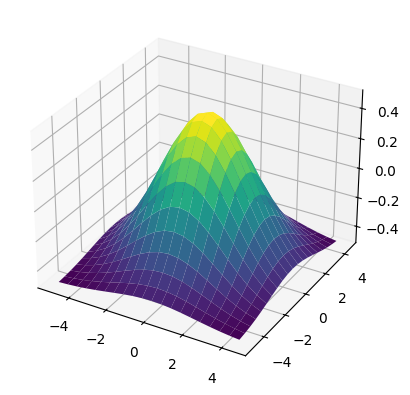

In [20]:
# Generate function data of Gauss function

x = np.arange(-5.0,5.0,0.5)
y = np.arange(-5.0,5.0,0.5)

xx, yy = np.meshgrid(x,y)

z = np.exp(-(xx**2 + yy**2) / 10) - 0.5



ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, z, rstride=1, cstride=1, cmap='viridis')

In [21]:

def data_generator_function_approx(): 

    #create data
    x = np.arange(-5.0,5.0,0.5)
    y = np.arange(-5.0,5.0,0.5)
    n = len(y)*len(x)
    xx, yy = np.meshgrid(x,y)
    z = np.exp(-(xx**2 + yy**2) / 10) - 0.5

    #reshape data
    targets = z.reshape(1,n)
    patterns = np.vstack([xx.reshape(1, n), yy.reshape(1, n)])

    # Add gausian noise to training data
    gauss05 = np.random.randn(targets.shape[0]) * 0.15
    #gauss15 = np.random.randn(targets.shape[1]) * 0.15

    targets_with_noise = targets + gauss05

    print(targets[0].shape)
    #shuffle data
    idx_shuffled = np.random.permutation(patterns.shape[1])
    patterns_shuffled = patterns[:,idx_shuffled]
    targets_shuffled = targets[:,idx_shuffled]
    targets_shuffled_noise = targets_shuffled + gauss05

    #add bias
    input_data_train_bias = np.vstack(tup=(patterns, np.ones((1,n))))
    input_data_train_shuffled_bias = np.vstack(tup=(patterns_shuffled, np.ones((1,n))))


    return input_data_train_bias, targets, input_data_train_shuffled_bias, targets_shuffled, targets_with_noise, targets_shuffled_noise


(400,)


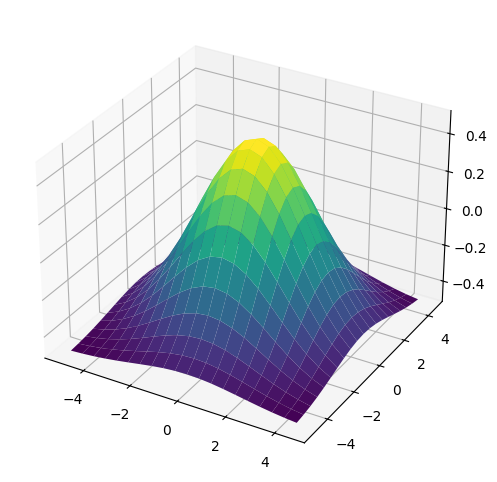

In [22]:
# test data generation and function approximation plotting
X, Y,X_shuffled,Y_shuffled, _, Y_noisy = data_generator_function_approx()
visualize_function_approx(Y)
#print(Y.shape)


Hidden nodes: 5, eta: 0.01, alpha: 0.9


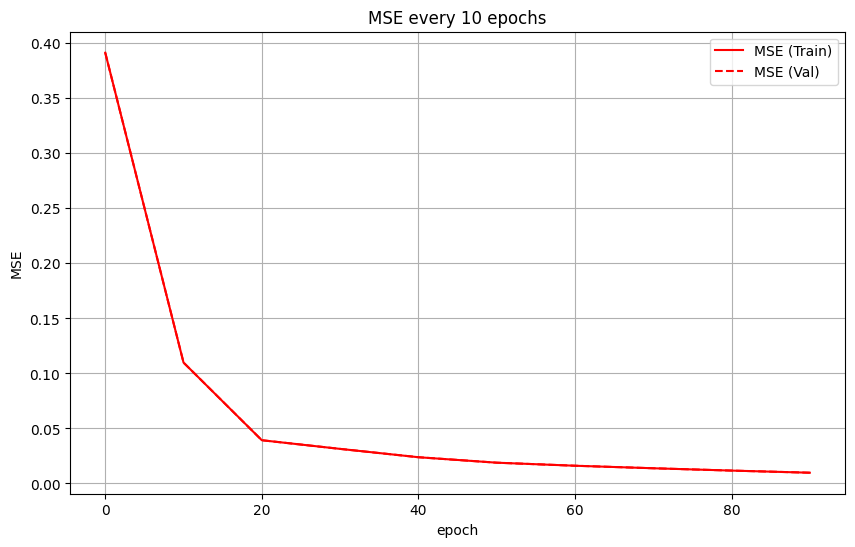

ValueError: too many values to unpack (expected 2)

In [23]:
y_predicted, _ = generalised_delta_rule(train_X=X, train_targets=Y,val_X=X, val_targets=Y, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=5, approximate_function= True)


visualize_function_approx(y_predicted)

Sample size: 10
Hidden nodes: 5, eta: 0.01, alpha: 0.9


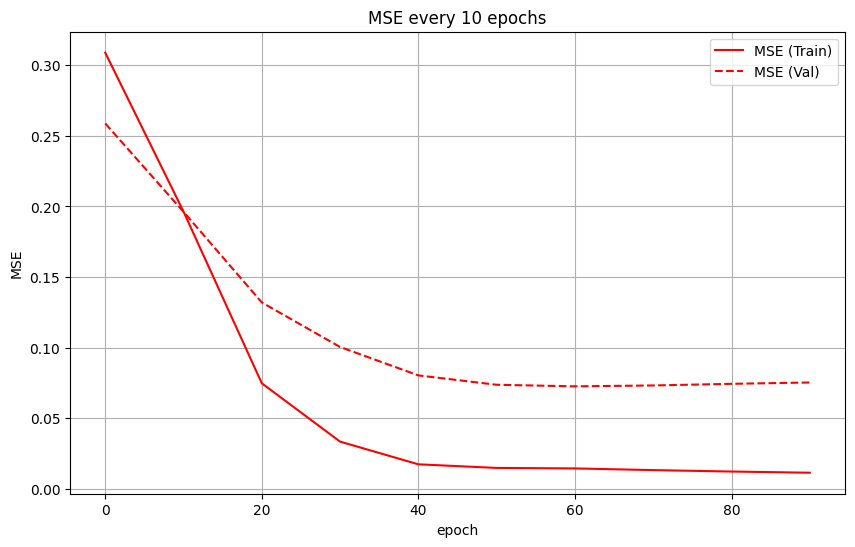

Sample size: 20
Hidden nodes: 5, eta: 0.01, alpha: 0.9


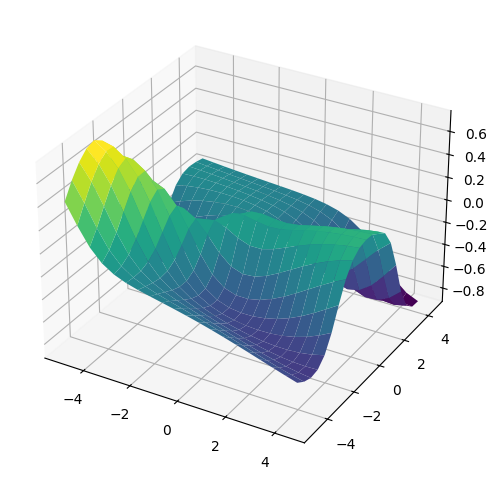

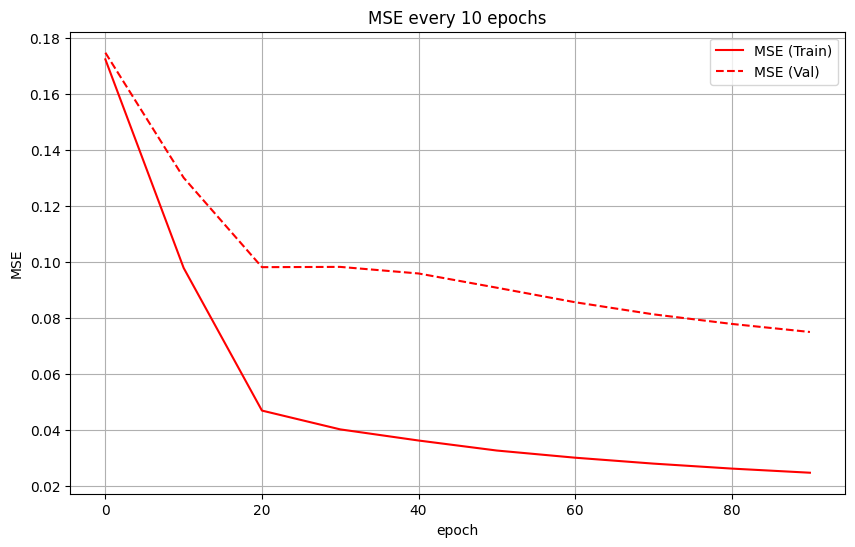

Sample size: 30
Hidden nodes: 5, eta: 0.01, alpha: 0.9


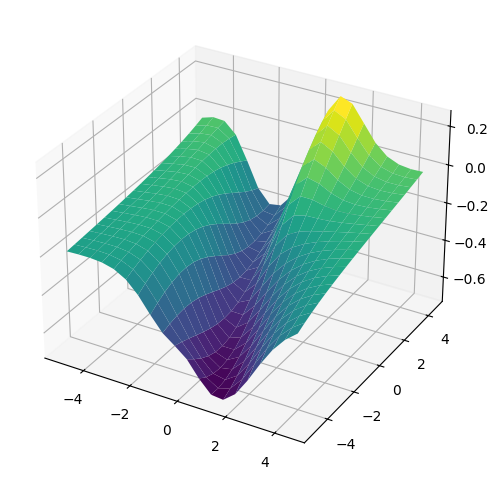

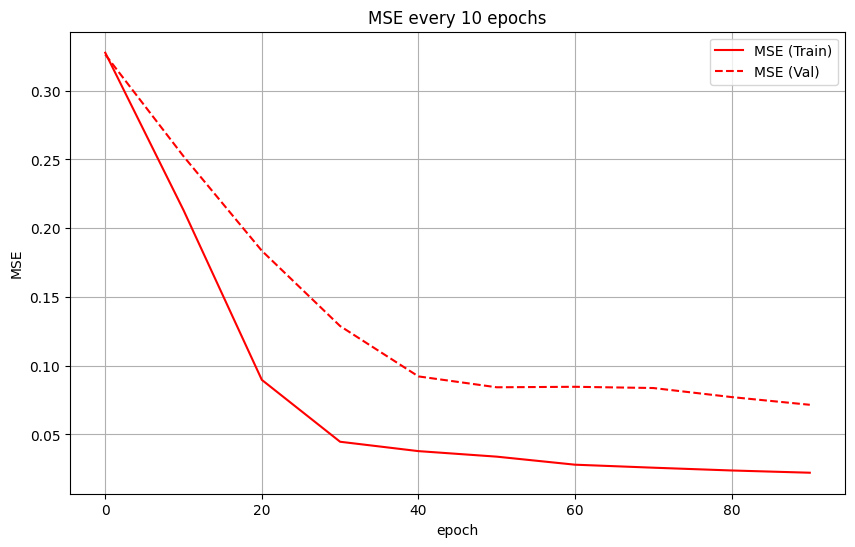

Sample size: 40
Hidden nodes: 5, eta: 0.01, alpha: 0.9


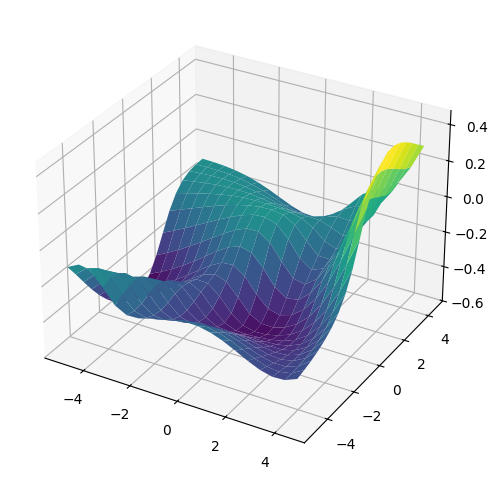

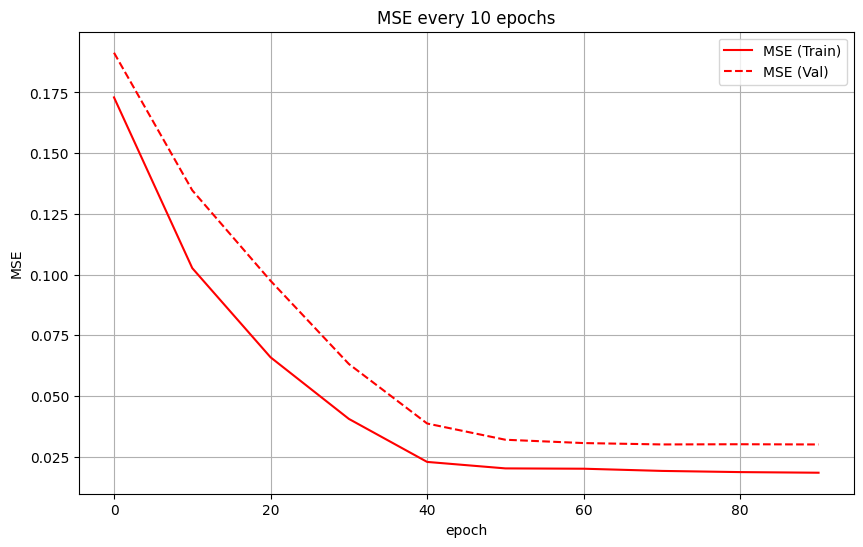

Sample size: 50
Hidden nodes: 5, eta: 0.01, alpha: 0.9


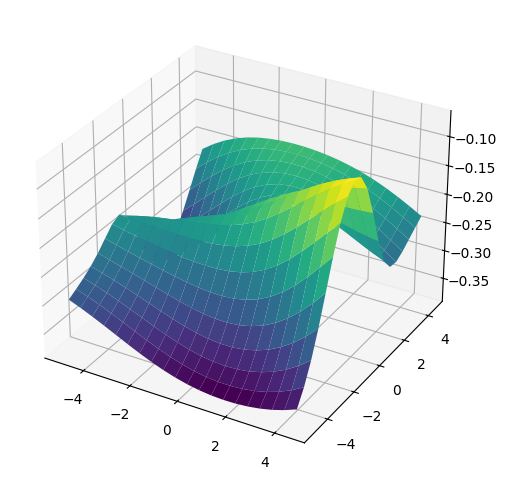

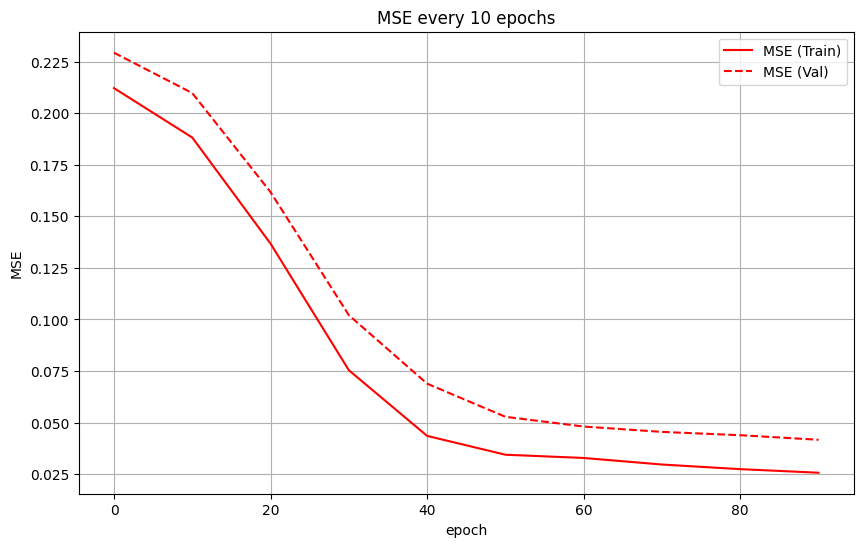

Sample size: 60
Hidden nodes: 5, eta: 0.01, alpha: 0.9


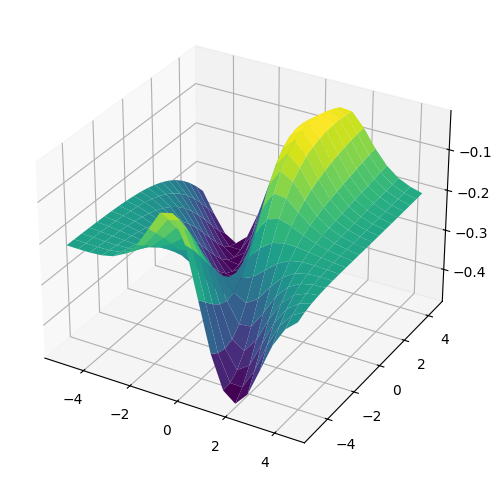

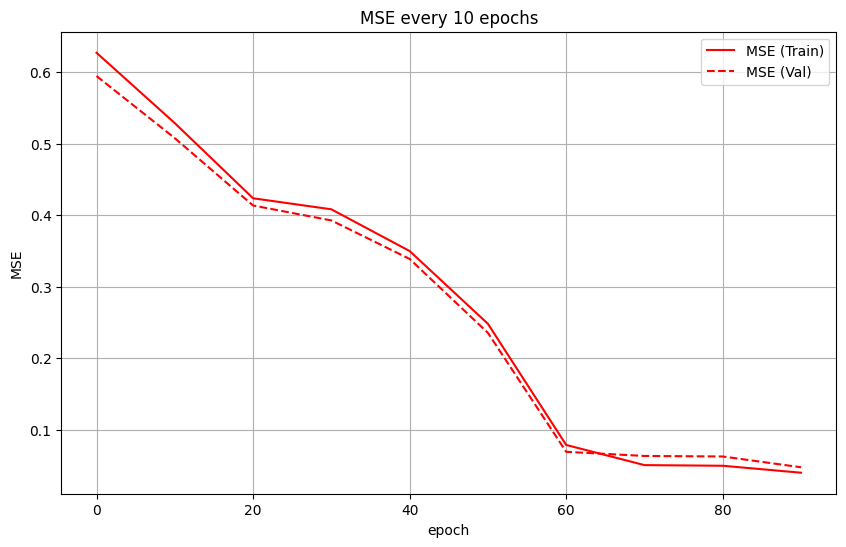

Sample size: 70
Hidden nodes: 5, eta: 0.01, alpha: 0.9


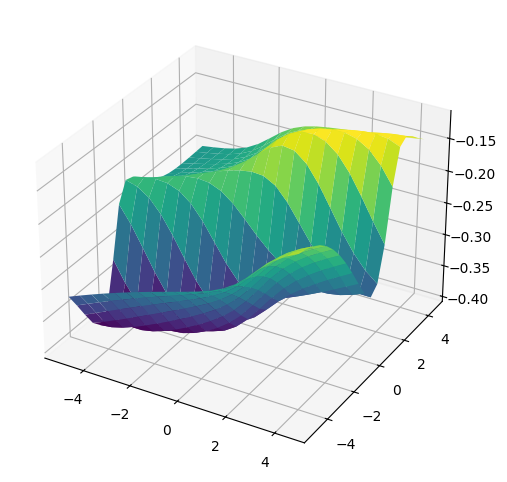

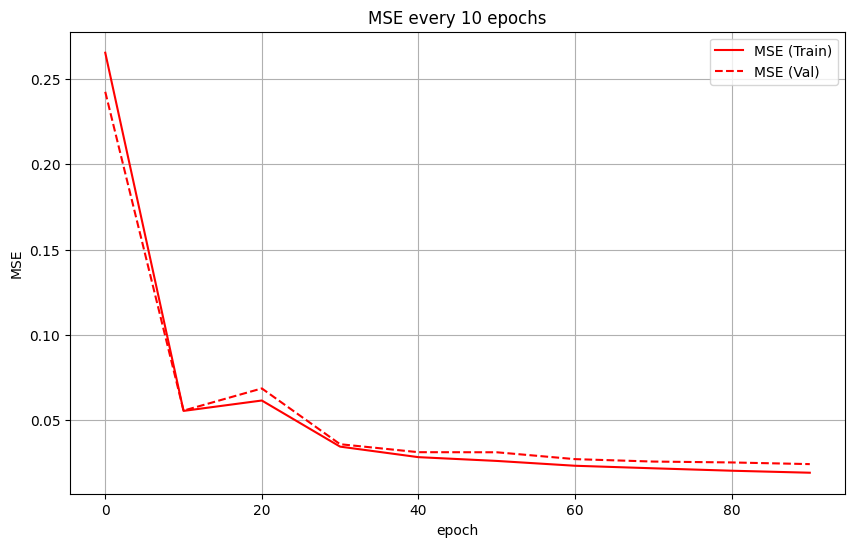

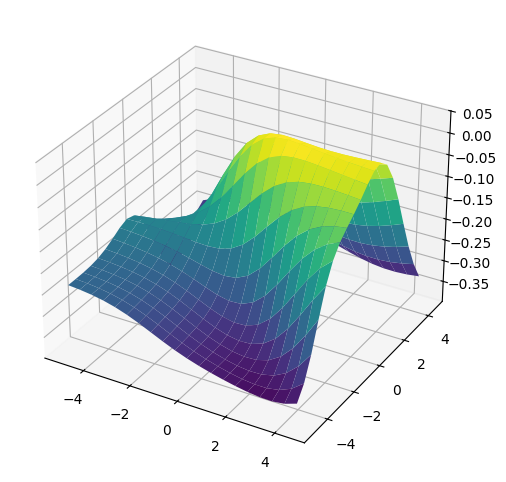

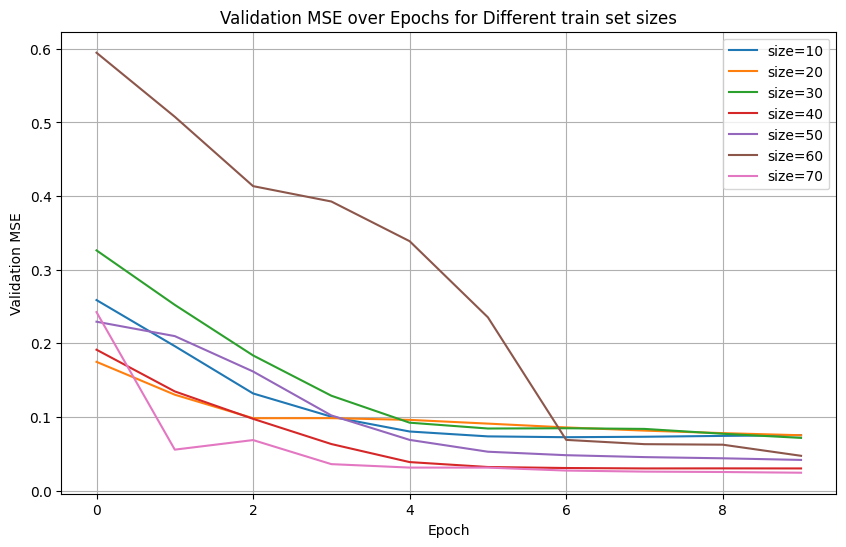

In [ ]:
X, Y,X_shuffled,Y_shuffled,_, Y_shuffled_noisy = data_generator_function_approx()

n_samples = 80

mse_val_list = []
mse_train_list = []

for i in range(10,n_samples, 10):

    print(f"Sample size: {i}")
    y_predicted, mse_validation, mse_train = generalised_delta_rule(
        train_X=X_shuffled[:,:i],
        train_targets=Y_shuffled_noisy[:,:i],
        val_X= X,
        val_targets=Y,
        epoch=100,
        eta=0.01,
        alpha=0.9,
        hidden_nodes=5,
        approximate_function= True)
    mse_val_list.append(mse_validation)
    mse_train_list.append(mse_train)
    #visualize_function_approx(y_predicted)




plt.figure(figsize=(10,6))
samples = np.arange(10,n_samples,10)


for i,mse in enumerate(mse_list):

    epochs = range(len(mse))
    plt.plot(epochs, mse, label=f'size={samples[i]}')
    plt.xlabel('Epoch')

plt.xlabel('Epoch')
plt.ylabel('Validation MSE')
plt.title('Validation MSE over Epochs for Different train set sizes')
plt.legend()
plt.grid(True)
plt.show()


## Varying number of nodes

In [168]:
X, Y,X_shuffled,Y_shuffled, _,_= data_generator_function_approx()

(400,)


In [169]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(

    X.transpose(),
    Y.transpose(),
    test_size=0.2,
    random_state=49
)

In [170]:
X_train = X_train.transpose()
X_validation = X_validation.transpose()
Y_train = Y_train.transpose()
Y_validation = Y_validation.transpose()

In [191]:
# Add gausian noise to training data

np.random.seed(1)
gauss05 = np.random.randn(Y_train.shape[0]) * 0.2
#gauss15 = np.random.randn(targets.shape[1]) * 0.15

Y_train_noisy = Y_train + gauss05 

In [192]:
n = 25

In [193]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from helper_functions import mse
from helper_functions import *

In [194]:
epochs = 10

epoch_list = np.arange(0,100,10)
print(epoch_list)

[ 0 10 20 30 40 50 60 70 80 90]


Number of nodes: 1
Hidden nodes: 1, eta: 0.01, alpha: 0.9


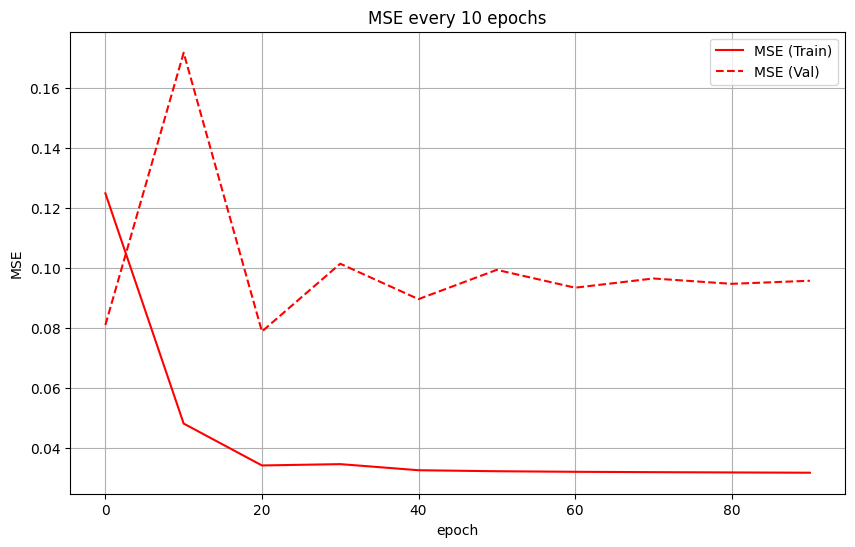

Number of nodes: 5
Hidden nodes: 5, eta: 0.01, alpha: 0.9


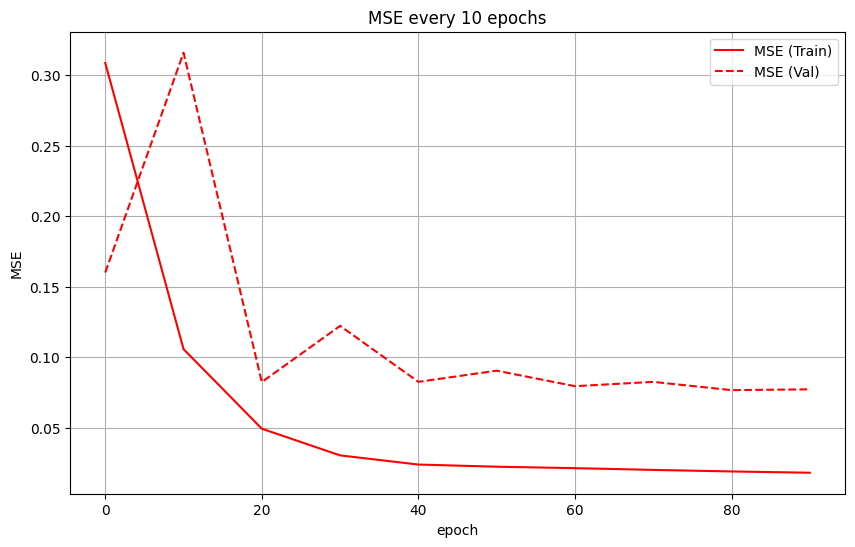

Number of nodes: 9
Hidden nodes: 9, eta: 0.01, alpha: 0.9


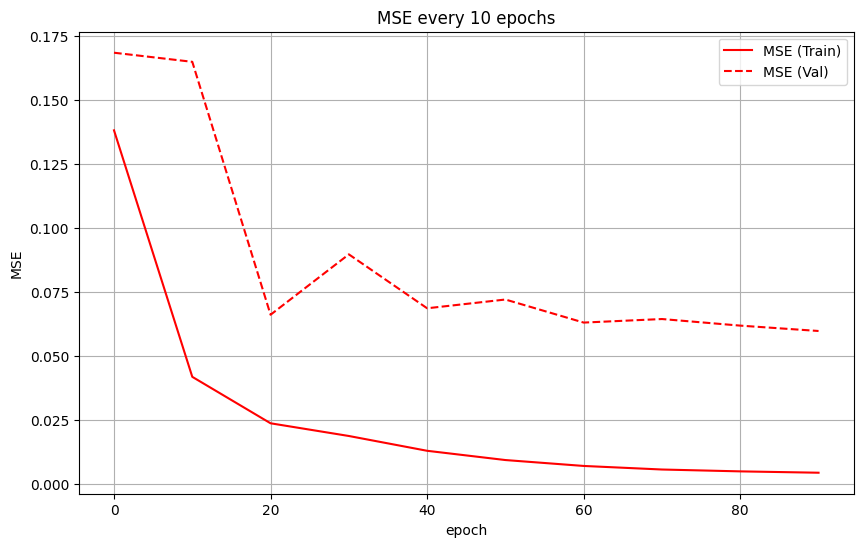

Number of nodes: 13
Hidden nodes: 13, eta: 0.01, alpha: 0.9


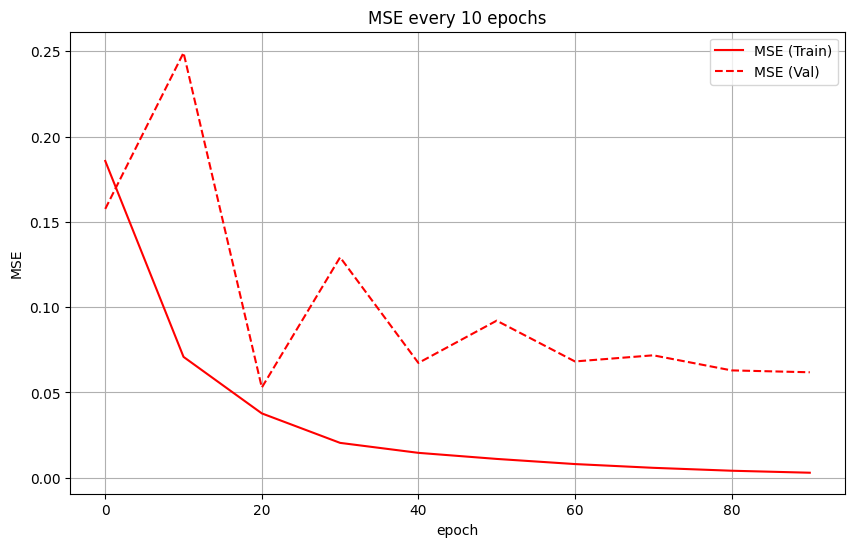

Number of nodes: 17
Hidden nodes: 17, eta: 0.01, alpha: 0.9


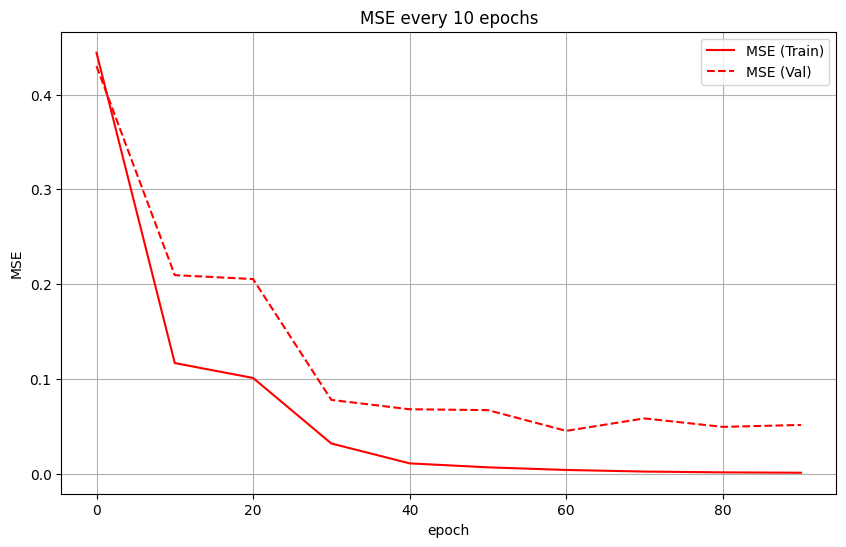

Number of nodes: 21
Hidden nodes: 21, eta: 0.01, alpha: 0.9


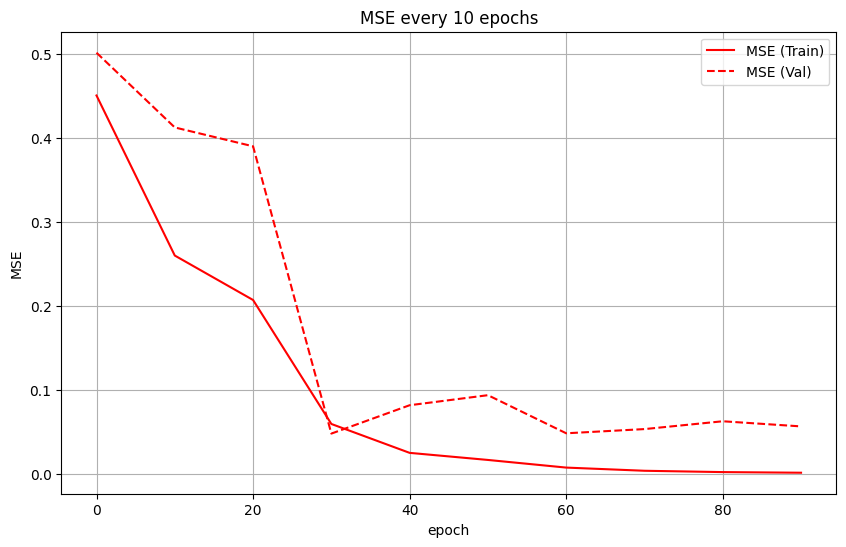

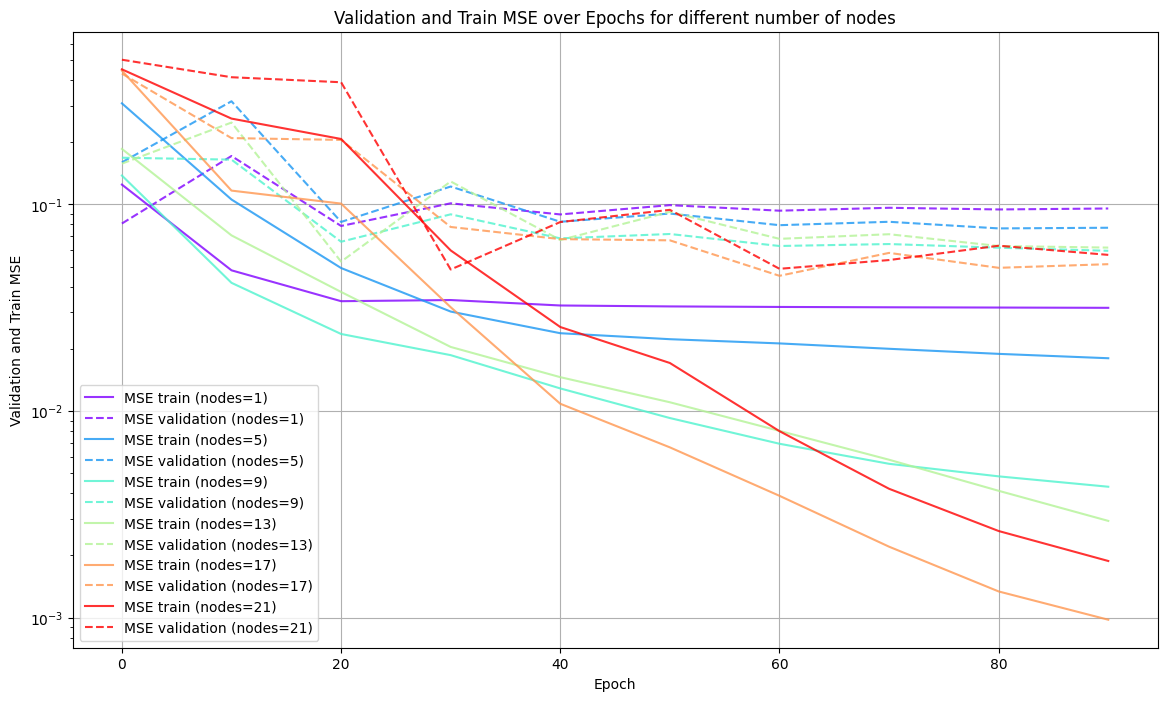

In [199]:


mse_validation_list = []
mse_train_list = []

for i in range(1,n, 4):
    #Lab requirements suggest to calculate the mse not only on the validation set but on all available data points
    print(f"Number of nodes: {i}")
    y_predicted, mse_validation, mse_train = generalised_delta_rule(
        train_X=X_train,
        train_targets=Y_train_noisy,
        val_X= X_validation,
        val_targets=Y_validation,
        epoch=100,
        eta=0.01,
        alpha=0.9,
        hidden_nodes=i,
        approximate_function= True)
        
    mse_validation_list.append(mse_validation)
    mse_train_list.append(mse_train)
    
    #visualize_function_approx(y_predicted)

plt.figure(figsize=(14,8))
node_count = np.arange(1,n,4)
colors = plt.cm.rainbow(np.linspace(0, 1, len(mse_train_list)))

for i, (train_mse,val_mse) in enumerate(zip(mse_train_list,mse_validation_list)):

    epochs = np.arange(0,100, 10)

    plt.plot(epochs, train_mse, '-', color=colors[i], 
            label=f'MSE train (nodes={node_count[i]})', alpha=0.8)

    plt.plot(epochs, val_mse, '--', color=colors[i], 
            label=f'MSE validation (nodes={node_count[i]})', alpha=0.8)
    

plt.xlabel('Epoch')
plt.ylabel('Validation and Train MSE')
plt.title('Validation and Train MSE over Epochs for different number of nodes')
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()
    

## Experiments with varying number of training samples

In [ ]:
from helper_functions import *

In [ ]:
X, Y,X_shuffled,Y_shuffled = data_generator_function_approx()


for split in np.arange(0.1, 1.0, 0.1):

    X_train, X_validation, Y_train, Y_validation = train_test_split(

    X.transpose(),
    Y.transpose(),
    test_size=round(split, 2),
    random_state=49
    )

    X_train = X_train.transpose()
    X_validation = X_validation.transpose()
    Y_train = Y_train.transpose()
    Y_validation = Y_validation.transpose()
    print(f"Samples used for training: {split:.2f}%")

    y_predicted = generalised_delta_rule(train_X=X_train, train_targets=Y_train,val_X=X_validation,val_targets=Y_validation, epoch=200, eta=0.01, alpha=0.9, hidden_nodes=5, approximate_function= True)
    #visualize_function_approx(y_predicted)
    
    

(400,)


ValueError: too many values to unpack (expected 4)

Alpha used for momentum: 0.50%
Hidden nodes: 5, eta: 0.01, alpha: 0.5


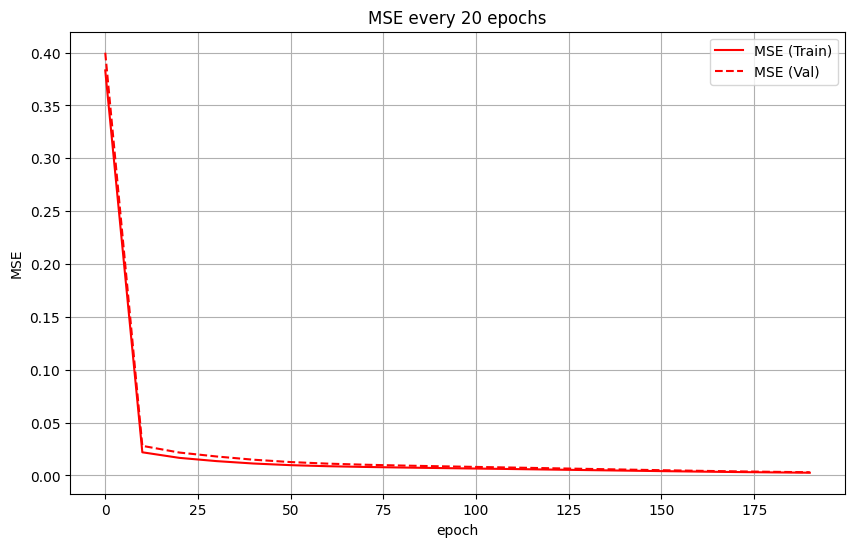

Alpha used for momentum: 0.60%
Hidden nodes: 5, eta: 0.01, alpha: 0.6


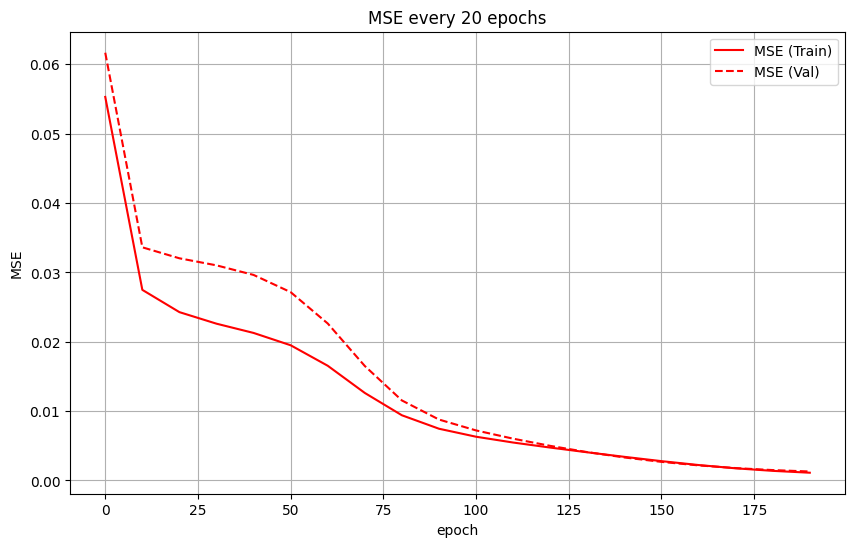

Alpha used for momentum: 0.70%
Hidden nodes: 5, eta: 0.01, alpha: 0.7


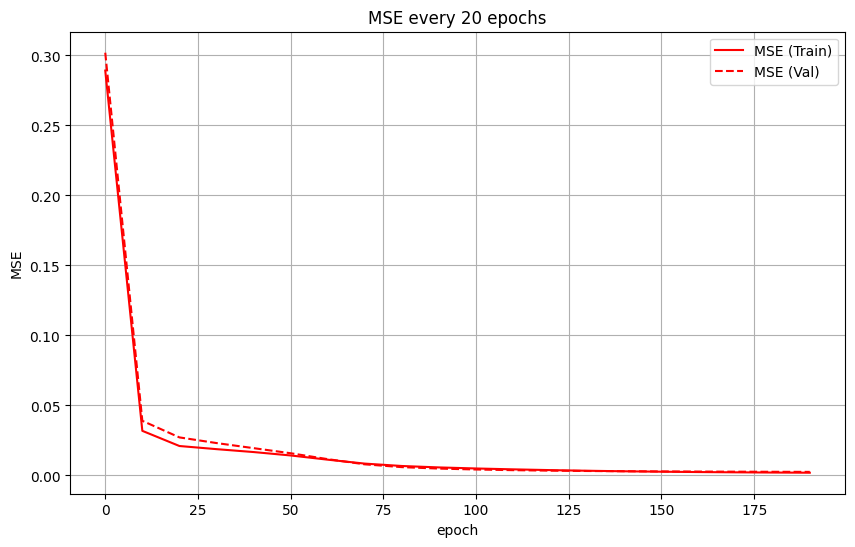

Alpha used for momentum: 0.80%
Hidden nodes: 5, eta: 0.01, alpha: 0.7999999999999999


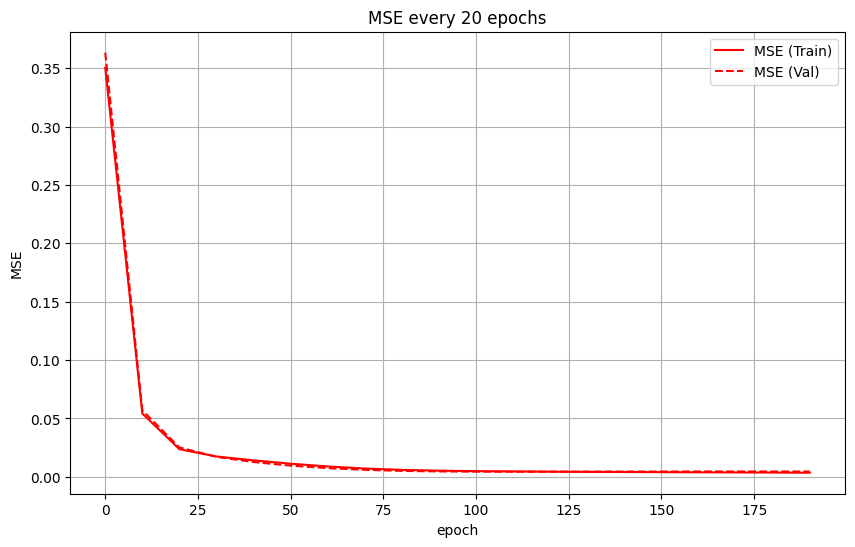

Alpha used for momentum: 0.90%
Hidden nodes: 5, eta: 0.01, alpha: 0.8999999999999999


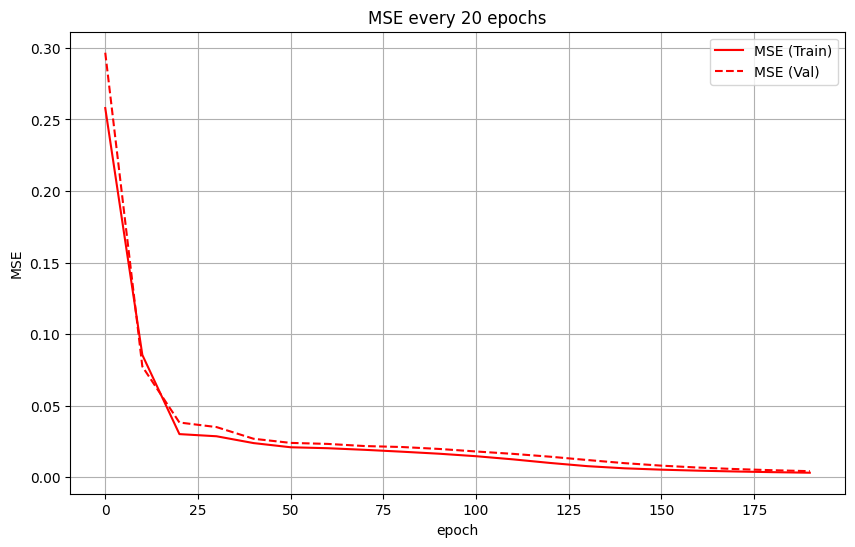

Alpha used for momentum: 1.00%
Hidden nodes: 5, eta: 0.01, alpha: 0.9999999999999999


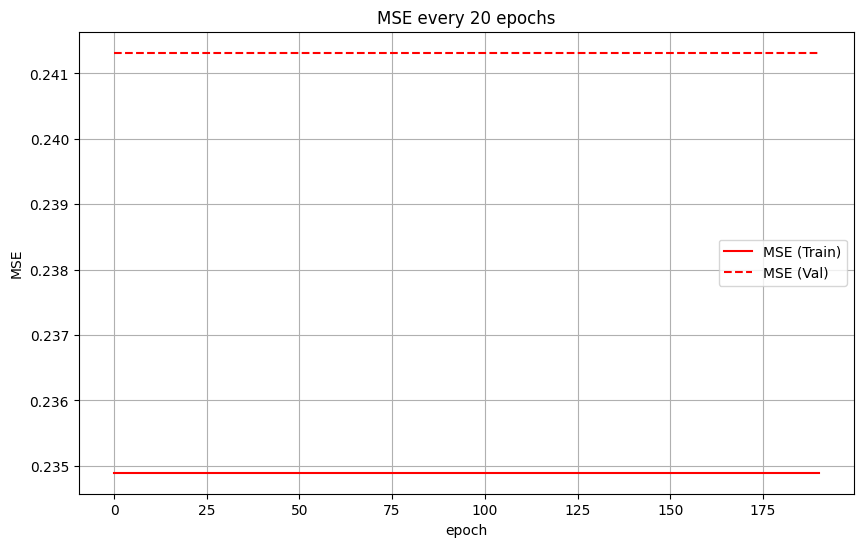

Alpha used for momentum: 1.10%
Hidden nodes: 5, eta: 0.01, alpha: 1.0999999999999999


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_52118/3459741700.py:3: RuntimeWarning: overflow encountered in exp
  phi = (2 / (1 + np.exp(-h_in))) - 1 #activation function


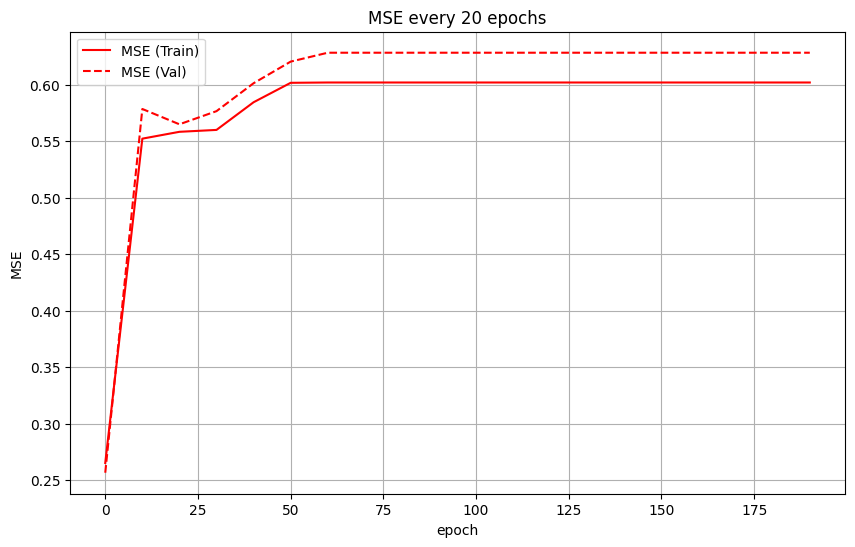

In [ ]:
from sklearn.model_selection import train_test_split


X, Y,X_shuffled,Y_shuffled = data_generator_function_approx()

X_train, X_validation, Y_train, Y_validation = train_test_split(

    X.transpose(),
    Y.transpose(),
    test_size=0.2,
    random_state=49
    )
X_train = X_train.transpose()
X_validation = X_validation.transpose()
Y_train = Y_train.transpose()
Y_validation = Y_validation.transpose()


mse_validation_list = []

for alpha in np.arange(0.5, 1.2, 0.1):

    print(f"Alpha used for momentum: {alpha:.2f}%")

    _, mse_validation = generalised_delta_rule(train_X=X_train, train_targets=Y_train,val_X=X_validation,val_targets=Y_validation, epoch=200, eta=0.01, alpha=alpha, hidden_nodes=5, approximate_function= True)
    #visualize_function_approx(y_predicted)
    mse_validation_list.append(mse_validation)
    

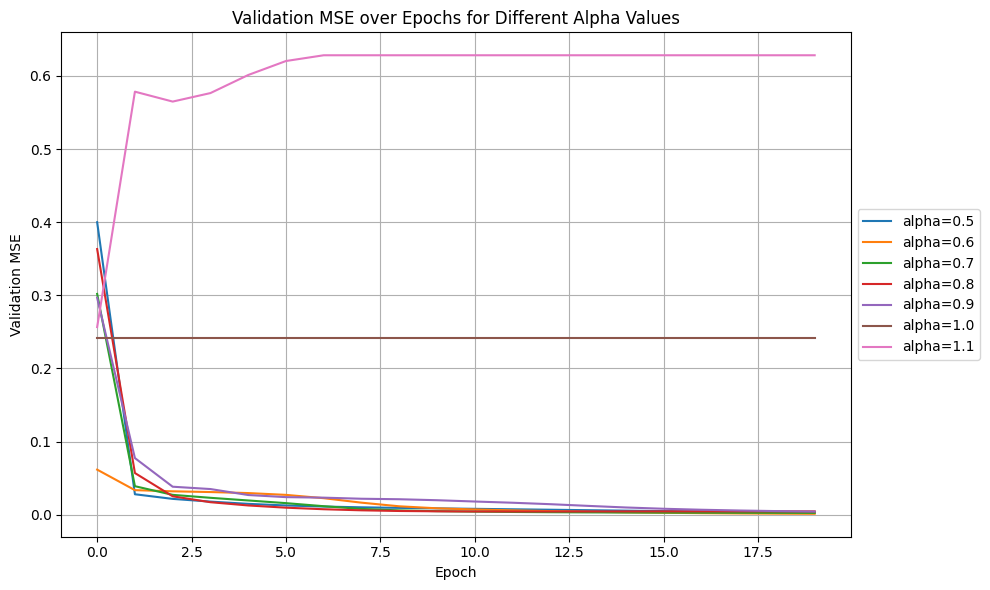

In [ ]:
alphas = np.arange(0.5, 2.0, 0.1)

plt.figure(figsize=(10, 6))

for i, mse in enumerate(mse_validation_list):
    epochs = range(len(mse))
    plt.plot(epochs, mse, label=f'alpha={alphas[i]:.1f}')
    plt.xlabel('Epoch')
    
plt.ylabel('Validation MSE')
plt.title('Validation MSE over Epochs for Different Alpha Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.grid(True)
plt.tight_layout()  
plt.show()